## (1.1) Importing libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation



Bad key "text.kerning_factor" on line 4 in
C:\conda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## (1.2) Importing all  datasets.

* **Artists** Dataset contains 10.000 unique Artists and the 4 most representetive tags of each Particular Artists
 * Some example of the tags include, the music genres each Artist plays or their respective country
 * Similarity between each Artist will be taken into account
* **Metrics** Dataset contains metadata for each song of different Artists
 * Metadata include song attributes such as loudness, energy, dancability and and valence
* **Colabor and songs** dataset contains over 76.000 unique user IDs and over 10.000 songs
 * For each song, the total number of times each user streamed the song is given as data points


In [3]:
#metrics
metrics = pd.read_csv('C:/Users/Φιλωτας Θεοδοσιου/Desktop/Uni/Data Mining/Project/SpotifyFeatures.csv')
#streams per user
colabor = pd.read_csv('C:/Users/Φιλωτας Θεοδοσιου/Desktop/Uni/Data Mining/Project/10000.txt', 
                      sep = '\t', header = None, names = ['user','song','play_count'])
#Songs and unique code
songs = pd.read_csv('C:/Users/Φιλωτας Θεοδοσιου/Desktop/Uni/Data Mining/Project/song_data.csv')
#Artists 
artists = pd.read_csv('C:/Users/Φιλωτας Θεοδοσιου/Desktop/Uni/Data Mining/Project/artists_final.csv')

##  2. Artists Dataset 

**When the Dataset was Scrapped from LastFM it contained over 2100 unique tags**

This huge number of unique tags would cause plenty of use on the recommendation system:

* Sparsity
* Plenty of insignificant tags
* Few similar tags between different Artists

This would result in **Bad and slow recommendations**

To deal with these kinds of problems, several approaches were implemented.

### 2.1 Cleaning the DataSet

#### Checking the format of the Artists (w. top tags) Dataframe

In [4]:
print('Columns :',artists.columns)
artists.head() 

Columns : Index(['Unnamed: 0', 'Unnamed: 0.1', 'name', 'playcount', 'listeners', 'mbid',
       'url', 'streamable', 'image', 'tags', 'tags_all'],
      dtype='object')


Unnamed: 0  Unnamed: 0.1           name  playcount  listeners  \
0           0             0     Kanye West  265531841    4494989   
1           1             1  Billie Eilish   41178444     634605   
2           2             2    Post Malone   42291126     697098   
3           3             3  Ariana Grande  132760469    1196871   
4           4             4       Coldplay  366749549    5456757   

                                   mbid  \
0  164f0d73-1234-4e2c-8743-d77bf2191051   
1                                   NaN   
2                                   NaN   
3  f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387   
4  cc197bad-dc9c-440d-a5b5-d52ba2e14234   

                                       url  streamable  \
0     https://www.last.fm/music/Kanye+West           0   
1  https://www.last.fm/music/Billie+Eilish           0   
2    https://www.last.fm/music/Post+Malone           0   
3  https://www.last.fm/music/Ariana+Grande           0   
4       https://www.last.fm/music/Coldplay           0   

                                               image  \
0  [{'#text': 'https://lastfm.freetls.fastly.net/...   
1  [{'#text': 'https://lastfm.freetls.fastly.net/...   
2  [{'#text': 'https://lastfm.freetls.fastly.net/...   
3  [{'#text': 'https://lastfm.freetls.fastly.net/...   
4  [{'#text': 'https://lastfm.freetls.fastly.net/...   

                         tags                                      tags_all  
0       Hip-Hop, rap, hip hop                    Hip-Hop, rap, hip hop, rnb  
1       pop, indie pop, indie             pop, indie pop, indie, electronic  
2          Hip-Hop, rap, trap                 Hip-Hop, rap, trap, cloud rap  
3  pop, female vocalists, rnb     pop, female vocalists, rnb, Ariana Grande  
4  rock, alternative, britpop  rock, alternative, britpop, alternative rock

As I am only interested in the artists name and their respective tags

**Every other column is removed**

In [5]:
col = ['name','playcount', 'listeners' , 'tags_all','tags']
artists = artists[col]
#Renaming the columns
artists = artists.rename(columns = {'tags_all':'Tags' , 'name':'Artist' , 'tags':'SecondOption'})
#artists=artists.drop_duplicates('Artist')
artists

Artist  playcount  listeners  \
0              Kanye West  265531841    4494989   
1           Billie Eilish   41178444     634605   
2             Post Malone   42291126     697098   
3           Ariana Grande  132760469    1196871   
4                Coldplay  366749549    5456757   
...                   ...        ...        ...   
13995      Kronos Quartet    3764692     304389   
13996         Wim Mertens    2574293     214676   
13997           The Seeds    1826848     215704   
13998  The Appleseed Cast    9818181     263834   
13999        Brand Nubian    1850181     228752   

                                                    Tags  \
0                             Hip-Hop, rap, hip hop, rnb   
1                      pop, indie pop, indie, electronic   
2                          Hip-Hop, rap, trap, cloud rap   
3              pop, female vocalists, rnb, Ariana Grande   
4           rock, alternative, britpop, alternative rock   
...                                                  ...   
13995  contemporary classical, Classical, String Quar...   
13996  contemporary classical, minimalism, piano, Cla...   
13997    Garage Rock, 60s, Psychedelic Rock, psychedelic   
13998                  post-rock, indie, indie rock, emo   
13999         Hip-Hop, rap, hip hop, underground hip-hop   

                                            SecondOption  
0                                  Hip-Hop, rap, hip hop  
1                                  pop, indie pop, indie  
2                                     Hip-Hop, rap, trap  
3                             pop, female vocalists, rnb  
4                             rock, alternative, britpop  
...                                                  ...  
13995  contemporary classical, Classical, String Quartet  
13996          contemporary classical, minimalism, piano  
13997                 Garage Rock, 60s, Psychedelic Rock  
13998                       post-rock, indie, indie rock  
13999                              Hip-Hop, rap, hip hop  

[14000 rows x 5 columns]

#### "Tags" column contains top 4 unique tags, while "second_option" contains top three.

I will check which collumn is best to be used




### 2.1.1 Some basic cleaning,
##### Before the use of the different techniques:


* Using title-case, removing blanks and dashes
* Extracting all the unique tags

In [6]:
artists['Tags'] = artists['Tags'].str.title().str.replace(' ','').str.replace('-','')


vect = CountVectorizer(lowercase = False)
AllTags = vect.fit_transform(artists['Tags'].values.astype('U'))
print(len(vect.get_feature_names()),'\n')
print(vect.get_feature_names() )

2107 

['00S', '070', '112', '1970SSoul', '19ThCentury', '2010S', '2019', '20ThCenturyClassical', '24Kgoldn', '2Ne1', '2Step', '30S', '40S', '4Ad', '50S', '5Stars', '60', '60S', '60SGirls', '60SPsychedelic', '70S', '80', '80S', '8Bit', '90S', '98Degrees', 'ABoogieWitDaHoodie', 'ACapella', 'ACappella', 'ACappellaMetal', 'AHa', 'Aanheid', 'Absofacto', 'Abstract', 'AbstractHipHop', 'Acapella', 'Accoustic', 'Ace', 'Acid', 'AcidHouse', 'AcidJazz', 'Acousic', 'Acousmatic', 'Acoustic', 'AcousticPop', 'AcousticPunk', 'AcousticRock', 'AcrossTheUniverse', 'Actor', 'Actors', 'Actress', 'AdamLevine', 'AdultContemporary', 'Africa', 'AfricainFrancais', 'African', 'Afrikaans', 'AfroDisco', 'AfroHouse', 'AfroTrap', 'Afrobeat', 'Afrobeats', 'Afroswing', 'Afterfall', 'Aggressive', 'Aggrotech', 'Aiesec', 'Alabama', 'AlanJackson', 'Alberta', 'Algerian', 'Algorithm', 'Alkopoligamia', 'All', 'AllThingsAnnoyingInTheWorldPutTogetherIntoOneStupidBitch', 'AltCountry', 'Alternative', 'AlternativeCountry', 'Alter

A Huge number of unique tags.

Will try to cut this number down as much as possible

#### After applying CountVectorizer to the "second_option" column, which contains top three tags,
#### I have decided to focus on 4 tags instead of 3, so I get more precise recommandations.

Will Start exploring the tags:

In [7]:
#Creating a new df with all the tags:
hope = pd.DataFrame(index = artists['Artist'] , columns = vect.get_feature_names() , data = AllTags.toarray())

#Will explore the tags:
#First of all I will check how many times each tag appers on different artists
#Tags which are rarely used will be removed
dd = np.array([np.sum(hope[i]) for i in hope.columns])
hope.loc['Sums'] = dd
hope

00S  070  112  1970SSoul  19ThCentury  2010S  2019  \
Artist                                                                   
Kanye West            0    0    0          0            0      0     0   
Billie Eilish         0    0    0          0            0      0     0   
Post Malone           0    0    0          0            0      0     0   
Ariana Grande         0    0    0          0            0      0     0   
Coldplay              0    0    0          0            0      0     0   
...                 ...  ...  ...        ...          ...    ...   ...   
Wim Mertens           0    0    0          0            0      0     0   
The Seeds             0    0    0          0            0      0     0   
The Appleseed Cast    0    0    0          0            0      0     0   
Brand Nubian          0    0    0          0            0      0     0   
Sums                  1    1    1          2            1      3     3   

                    20ThCenturyClassical  24Kgoldn  2Ne1  ...  YoungMoney  \
Artist                                                    ...               
Kanye West                             0         0     0  ...           0   
Billie Eilish                          0         0     0  ...           0   
Post Malone                            0         0     0  ...           0   
Ariana Grande                          0         0     0  ...           0   
Coldplay                               0         0     0  ...           0   
...                                  ...       ...   ...  ...         ...   
Wim Mertens                            0         0     0  ...           0   
The Seeds                              0         0     0  ...           0   
The Appleseed Cast                     0         0     0  ...           0   
Brand Nubian                           0         0     0  ...           0   
Sums                                   2         1     2  ...           2   

                    Youngstar  Youtube  \
Artist                                   
Kanye West                  0        0   
Billie Eilish               0        0   
Post Malone                 0        0   
Ariana Grande               0        0   
Coldplay                    0        0   
...                       ...      ...   
Wim Mertens                 0        0   
The Seeds                   0        0   
The Appleseed Cast          0        0   
Brand Nubian                0        0   
Sums                        5        7   

                    YouveGotMeBewitchedCauseImUnderYourSpellOhOhOh  Yuke  \
Artist                                                                     
Kanye West                                                       0     0   
Billie Eilish                                                    0     0   
Post Malone                                                      0     0   
Ariana Grande                                                    0     0   
Coldplay                                                         0     0   
...                                                            ...   ...   
Wim Mertens                                                      0     0   
The Seeds                                                        0     0   
The Appleseed Cast                                               0     0   
Brand Nubian                                                     0     0   
Sums                                                             3     2   

                    ZacBrownBand  ZacEfron  Zambia  Zxzw  nan  
Artist                                                         
Kanye West                     0         0       0     0    0  
Billie Eilish                  0         0       0     0    0  
Post Malone                    0         0       0     0    0  
Ariana Grande                  0         0       0     0    0  
Coldplay                       0         0       0     0    0  
...                          ...       ...     ...   ...  ...  
Wim Mer

In [8]:
#Some statistics for the number of appearances of each tag
print("Mean value of Appearances : ",np.mean(dd))
print('\nMax: ',np.max(dd))
print('\nMin: ',np.min(dd))
print('\nTags that appear once: ' , len(hope.transpose()[hope.transpose()['Sums'] == 1]))
print('Tags that appear once or twice: ' , len(hope.transpose()[hope.transpose()['Sums'] < 3]))
print('Tags that appear less than 4 times: ' , len(hope.transpose()[hope.transpose()['Sums'] < 4]))

Mean value of Appearances :  25.51922164214523

Max:  2516

Min:  1

Tags that appear once:  693
Tags that appear once or twice:  1217
Tags that appear less than 4 times:  1370


### 2.2  First Approach:
#### Noise Removal

Over 1370 tags appear in less than 4 Artists

I will get rid of the tags that appear a few times , as they wont contribute in any recommandations.

In a dataset of 10.000 observations it would be unlikeable to find these tags many times and take advantage of them.

##### For these reason i will treat them as noise/outliers and will get rid of them.

In [63]:
#REMOVING TAGS WHICH APPER ON LESS THAN 4 ARTISTS 
to_delete = hope.transpose()[hope.transpose()['Sums'] < 4].index

#this is the fastest way to remove these tags
new_tags = []
artists['Tags'] = artists['Tags'].astype(str)
for i in range(len(artists)):
    d = artists['Tags'][i].split(',')
    
    cleaned = [d[j] for j in range(len(d)) if d[j]  not in to_delete  ]
    new_tags.append(cleaned)
    #Checking if the method works and which tags are being removed
    if (len(cleaned) < 4):
        print('\nold:' , cleaned)
        print('new:' , d)
    

artists['NewTags'] = new_tags
artists['NewTags'] = np.array(artists['NewTags'].apply(lambda x: ",".join(x) ) )
artists
    


old: ['Pop', 'FemaleVocalists', 'Rnb']
new: ['Pop', 'FemaleVocalists', 'Rnb', 'ArianaGrande']

old: ['HipHop', 'Rap', 'HipHop']
new: ['HipHop', 'Rap', 'CountryRap', 'HipHop']

old: ['Pop', 'Dance', 'FemaleVocalists']
new: ['Pop', 'Dance', 'FemaleVocalists', 'BritneySpears']

old: ['HipHop', 'Rap', 'UndergroundHipHop']
new: ['HipHop', 'Rap', 'UndergroundHipHop', 'Pittsburgh']

old: ['KPop', 'Kpop', 'Korean']
new: ['KPop', 'Kpop', 'Korean', 'Bts']

old: ['Pop', 'BlackMetal', 'Rnb']
new: ['Pop', 'BlackMetal', 'JustinBieber', 'Rnb']

old: ['Trap', 'HipHop', 'Rap']
new: ['Trap', 'HipHop', 'Rap', 'Yeah']

old: ['HipHop', 'Rap', 'HipHop']
new: ['HipHop', 'Rap', 'Biracial', 'HipHop']

old: ['Rnb', 'HipHop', 'Rap']
new: ['Rnb', 'HipHop', 'ChrisBrown', 'Rap']

old: ['HipHop', 'Rap', 'Trap']
new: ['HipHop', 'Rap', 'Trap', 'Dababy']

old: ['HipHop', 'Rap', 'HipHop']
new: ['HipHop', 'Rap', 'HipHop', 'GoodMusic']

old: ['PowerMetal', 'Swedish']
new: ['PowerMetal', 'NeoclassicalMetal', 'Swedish', 'N

Artist  playcount  listeners  \
0              Kanye West  265531841    4494989   
1           Billie Eilish   41178444     634605   
2             Post Malone   42291126     697098   
3           Ariana Grande  132760469    1196871   
4                Coldplay  366749549    5456757   
...                   ...        ...        ...   
13995      Kronos Quartet    3764692     304389   
13996         Wim Mertens    2574293     214676   
13997           The Seeds    1826848     215704   
13998  The Appleseed Cast    9818181     263834   
13999        Brand Nubian    1850181     228752   

                                                    Tags  \
0                                  HipHop,Rap,HipHop,Rnb   
1                          Pop,IndiePop,Indie,Electronic   
2                               HipHop,Rap,Trap,CloudRap   
3                   Pop,FemaleVocalists,Rnb,ArianaGrande   
4               Rock,Alternative,Britpop,AlternativeRock   
...                                                  ...   
13995  ContemporaryClassical,Classical,StringQuartet,...   
13996   ContemporaryClassical,Minimalism,Piano,Classical   
13997         GarageRock,60S,PsychedelicRock,Psychedelic   
13998                       PostRock,Indie,IndieRock,Emo   
13999                HipHop,Rap,HipHop,UndergroundHipHop   

                                            SecondOption  \
0                                  Hip-Hop, rap, hip hop   
1                                  pop, indie pop, indie   
2                                     Hip-Hop, rap, trap   
3                             pop, female vocalists, rnb   
4                             rock, alternative, britpop   
...                                                  ...   
13995  contemporary classical, Classical, String Quartet   
13996          contemporary classical, minimalism, piano   
13997                 Garage Rock, 60s, Psychedelic Rock   
13998                       post-rock, indie, indie rock   
13999                              Hip-Hop, rap, hip hop   

                                                NewTags  
0                                 HipHop,Rap,HipHop,Rnb  
1                         Pop,IndiePop,Indie,Electronic  
2                              HipHop,Rap,Trap,CloudRap  
3                               Pop,FemaleVocalists,Rnb  
4              Rock,Alternative,Britpop,AlternativeRock  
...                                                 ...  
13995      ContemporaryClassical,Classical,Instrumental  
13996  ContemporaryClassical,Minimalism,Piano,Classical  
13997        GarageRock,60S,PsychedelicRock,Psychedelic  
13998                      PostRock,Indie,IndieRock,Emo  
13999               HipHop,Rap,HipHop,UndergroundHipHop  

[14000 rows x 6 columns]

##### Double-Checking if all tags are removed

In [64]:
#Running vectorizer again
vect = CountVectorizer(lowercase = False)
AllTags = vect.fit_transform(artists['NewTags'].values)
#print(len(vect.get_feature_names()),'\n')
#print(vect.get_feature_names() )
hope = pd.DataFrame(index = artists['Artist'] , columns = vect.get_feature_names() , data = AllTags.toarray())

dd = np.array([np.sum(hope[i]) for i in hope.columns])
hope.loc['Sums'] = dd
hope.transpose()[hope.transpose()['Sums'] < 4]


Artist  Kanye West  Billie Eilish  Post Malone  Ariana Grande  Coldplay  \
60               0              0            0              0         0   
80               0              0            0              0         0   
Ayo              0              0            0              0         0   
Death            0              0            0              0         0   
Roll             0              0            0              0         0   
Singer           0              0            0              0         0   
Teo              0              0            0              0         0   

Artist  Lana Del Rey  Tame Impala  Queen  Ed Sheeran  The Beatles  ...  W00DS  \
60                 0            0      0           0            0  ...      0   
80                 0            0      0           0            0  ...      0   
Ayo                0            0      0           0            0  ...      0   
Death              0            0      0           0            0  ...      0   
Roll               0            0      0           0            0  ...      0   
Singer             0            0      0           0            0  ...      0   
Teo                0            0      0           0            0  ...      0   

Artist  Datsik  Jerry Douglas  Lo Moon  Kronos Quartet  Wim Mertens  \
60           0              0        0               0            0   
80           0              0        0               0            0   
Ayo          0              0        0               0            0   
Death        0              0        0               0            0   
Roll         0              0        0               0            0   
Singer       0              0        0               0            0   
Teo          0              0        0               0            0   

Artist  The Seeds  The Appleseed Cast  Brand Nubian  Sums  
60              0                   0             0     1  
80              0                   0             0     1  
Ayo             0                   0             0     2  
Death           0                   0             0     1  
Roll            0                   0             0     2  
Singer          0                   0             0     1  
Teo             0                   0             0     2  

[7 rows x 14001 columns]

7 more tags which I will remove manualy!


In [65]:
a = hope.transpose()[hope.transpose()['Sums'] < 4].index
a = a.astype(str)
for i in a:
    artists['NewTags'] = artists['NewTags'].replace(i,'')

    
#Keeping only the new tags:    
artists = artists[['Artist','NewTags']]
artists = artists.rename(columns={'NewTags':'Tags'})
artists

Artist                                              Tags
0              Kanye West                             HipHop,Rap,HipHop,Rnb
1           Billie Eilish                     Pop,IndiePop,Indie,Electronic
2             Post Malone                          HipHop,Rap,Trap,CloudRap
3           Ariana Grande                           Pop,FemaleVocalists,Rnb
4                Coldplay          Rock,Alternative,Britpop,AlternativeRock
...                   ...                                               ...
13995      Kronos Quartet      ContemporaryClassical,Classical,Instrumental
13996         Wim Mertens  ContemporaryClassical,Minimalism,Piano,Classical
13997           The Seeds        GarageRock,60S,PsychedelicRock,Psychedelic
13998  The Appleseed Cast                      PostRock,Indie,IndieRock,Emo
13999        Brand Nubian               HipHop,Rap,HipHop,UndergroundHipHop

[14000 rows x 2 columns]

In [66]:
vect = CountVectorizer(lowercase = False)
AllTags = vect.fit_transform(artists['Tags'])
vectorizer = pd.DataFrame(index = artists['Artist'] , columns = vect.get_feature_names() , data = AllTags.toarray())
vectorizer

40S  50S  60  60S  70S  80  80S  8Bit  90S  ACappella  \
Artist                                                                      
Kanye West            0    0   0    0    0   0    0     0    0          0   
Billie Eilish         0    0   0    0    0   0    0     0    0          0   
Post Malone           0    0   0    0    0   0    0     0    0          0   
Ariana Grande         0    0   0    0    0   0    0     0    0          0   
Coldplay              0    0   0    0    0   0    0     0    0          0   
...                 ...  ...  ..  ...  ...  ..  ...   ...  ...        ...   
Kronos Quartet        0    0   0    0    0   0    0     0    0          0   
Wim Mertens           0    0   0    0    0   0    0     0    0          0   
The Seeds             0    0   0    1    0   0    0     0    0          0   
The Appleseed Cast    0    0   0    0    0   0    0     0    0          0   
Brand Nubian          0    0   0    0    0   0    0     0    0          0   

                    ...  WitchHouse  Wonky  World  WorldMusic  Worship  \
Artist              ...                                                  
Kanye West          ...           0      0      0           0        0   
Billie Eilish       ...           0      0      0           0        0   
Post Malone         ...           0      0      0           0        0   
Ariana Grande       ...           0      0      0           0        0   
Coldplay            ...           0      0      0           0        0   
...                 ...         ...    ...    ...         ...      ...   
Kronos Quartet      ...           0      0      0           0        0   
Wim Mertens         ...           0      0      0           0        0   
The Seeds           ...           0      0      0           0        0   
The Appleseed Cast  ...           0      0      0           0        0   
Brand Nubian        ...           0      0      0           0        0   

                    WuTang  XFactor  Youngstar  Youtube  nan  
Artist                                                        
Kanye West               0        0          0        0    0  
Billie Eilish            0        0          0        0    0  
Post Malone              0        0          0        0    0  
Ariana Grande            0        0          0        0    0  
Coldplay                 0        0          0        0    0  
...                    ...      ...        ...      ...  ...  
Kronos Quartet           0        0          0        0    0  
Wim Mertens              0        0          0        0    0  
The Seeds                0        0          0        0    0  
The Appleseed Cast       0        0          0        0    0  
Brand Nubian             0        0          0        0    0  

[14000 rows x 744 columns]

### 2.3 Second Approach
#### Similar names

Many tags had the same name but a character being different(whitespace,special characters or typing errors)

Some examples include:

* Hip Hop and HipHop
* French and France
* PostRock and Post_Rock

To deal with these kind of problems:

**Will calculate the Levenshtein distance(number of different characters) between every tag, by creating an nxn matrix**
 
 * I will then explore the tags which have distance bellow the threshold number of  3 characters.
 * If they are identical, I will transform them in order to merge them

In [67]:
%%time
#create an 744x744 distance matrix for the columns
#with levenshtein distance between each element as data points
from nltk import edit_distance #the Levenshtein distance in nltk
from scipy.spatial.distance import pdist, squareform

elements = vectorizer.columns
anew= np.array(elements).reshape(-1,1)

distance_matrix = pdist(anew , lambda x,y : edit_distance(x[0] , y[0]))

# get square matrix
print(squareform(distance_matrix)) 

[[0. 1. 2. ... 9. 7. 3.]
 [1. 0. 2. ... 9. 7. 3.]
 [2. 2. 0. ... 9. 7. 3.]
 ...
 [9. 9. 9. ... 0. 6. 7.]
 [7. 7. 7. ... 6. 0. 7.]
 [3. 3. 3. ... 7. 7. 0.]]
Wall time: 29.2 s


In [68]:
distances = pd.DataFrame(index = elements , columns = elements , data = squareform(distance_matrix))
distances

40S  50S   60  60S  70S   80  80S  8Bit  90S  ACappella  ...  \
40S        0.0  1.0  2.0  1.0  1.0  2.0  1.0   4.0  1.0        9.0  ...   
50S        1.0  0.0  2.0  1.0  1.0  2.0  1.0   4.0  1.0        9.0  ...   
60         2.0  2.0  0.0  1.0  2.0  1.0  2.0   4.0  2.0        9.0  ...   
60S        1.0  1.0  1.0  0.0  1.0  2.0  1.0   4.0  1.0        9.0  ...   
70S        1.0  1.0  2.0  1.0  0.0  2.0  1.0   4.0  1.0        9.0  ...   
...        ...  ...  ...  ...  ...  ...  ...   ...  ...        ...  ...   
WuTang     6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0  6.0        9.0  ...   
XFactor    7.0  7.0  7.0  7.0  7.0  7.0  7.0   6.0  7.0        8.0  ...   
Youngstar  9.0  9.0  9.0  9.0  9.0  9.0  9.0   8.0  9.0        9.0  ...   
Youtube    7.0  7.0  7.0  7.0  7.0  7.0  7.0   6.0  7.0        9.0  ...   
nan        3.0  3.0  3.0  3.0  3.0  3.0  3.0   4.0  3.0        8.0  ...   

           WitchHouse  Wonky  World  WorldMusic  Worship  WuTang  XFactor  \
40S              10.0    5.0    5.0        10.0      7.0     6.0      7.0   
50S              10.0    5.0    5.0        10.0      7.0     6.0      7.0   
60               10.0    5.0    5.0        10.0      7.0     6.0      7.0   
60S              10.0    5.0    5.0        10.0      7.0     6.0      7.0   
70S              10.0    5.0    5.0        10.0      7.0     6.0      7.0   
...               ...    ...    ...         ...      ...     ...      ...   
WuTang            9.0    5.0    5.0         9.0      6.0     0.0      7.0   
XFactor           8.0    7.0    7.0        10.0      7.0     7.0      0.0   
Youngstar        10.0    7.0    8.0         9.0      7.0     8.0      7.0   
Youtube           8.0    6.0    6.0         8.0      6.0     6.0      7.0   
nan              10.0    4.0    5.0        10.0      7.0     4.0      6.0   

           Youngstar  Youtube  nan  
40S              9.0      7.0  3.0  
50S              9.0      7.0  3.0  
60               9.0      7.0  3.0  
60S              9.0      7.0  3.0  
70S              9.0      7.0  3.0  
...              ...      ...  ...  
WuTang           8.0      6.0  4.0  
XFactor          7.0      7.0  6.0  
Youngstar        0.0      6.0  7.0  
Youtube          6.0      0.0  7.0  
nan              7.0      7.0  0.0  

[744 rows x 744 columns]

Starting with values which have distance equal to 1

In [69]:
distances = pd.DataFrame(index = elements , columns = elements , data = squareform(distance_matrix))

test = []
for i in distances.columns:
    short = distances[distances[i] == 1][i].index.values
    if not short.any():
        test.append(['0'])
    else:
        
        test.append(short)
distances['shorts'] = test
distances['shorts'] = distances['shorts'].apply(lambda x: ",".join(x) )
distances = distances[(distances['shorts'] != '0')][['shorts']]


distances = distances.reset_index()
distance_equal_1 = np.array([(distances.iloc[i]['shorts'],distances.iloc[i]['index'])  for i in range(0,len(distances)-1) 
            if distances.iloc[i+1]['index'] in distances.iloc[i]['shorts'] ])
distance_equal_1

array([['50S,60S,70S,80S,90S', '40S'],
       ['40S,60S,70S,80S,90S', '50S'],
       ['60S,80', '60'],
       ['40S,50S,60,70S,80S,90S', '60S'],
       ['40S,50S,60S,80S,90S', '70S'],
       ['60,80S', '80'],
       ['40S,50S,60S,70S,80,90S', '80S'],
       ['Americana', 'American'],
       ['Australian', 'Australia'],
       ['Beats', 'Beat'],
       ['Boybands', 'Boyband'],
       ['Brazil', 'Brasil'],
       ['Chill', 'Chile'],
       ['Chillhop', 'ChillHop'],
       ['Composers', 'Composer'],
       ['Covers', 'Cover'],
       ['Cuban', 'Cuba'],
       ['Drums', 'Drum'],
       ['Ecm,Edm', 'Ebm'],
       ['Ebm,Edm', 'Ecm'],
       ['Electronica', 'Electronic'],
       ['Exo', 'Emo'],
       ['FemaleVocalists', 'FemaleVocalist'],
       ['Funk,Funny', 'Funky'],
       ['Germany', 'German'],
       ['GirlGroups', 'GirlGroup'],
       ['God', 'Goa'],
       ['Hiphop', 'HipHop'],
       ['Israeli', 'Israel'],
       ['Jamaican', 'Jamaica'],
       ['Latino', 'Latin'],
       ['Lofi', '

After checking them one by one , I am removing those that might be similar, but are not identical

In [70]:
distance_equal_1 = np.delete(distance_equal_1,(0,1,3,4,6,12,18,21,23,26,36,42),0)
distance_equal_1

array([['60S,80', '60'],
       ['60,80S', '80'],
       ['Americana', 'American'],
       ['Australian', 'Australia'],
       ['Beats', 'Beat'],
       ['Boybands', 'Boyband'],
       ['Brazil', 'Brasil'],
       ['Chillhop', 'ChillHop'],
       ['Composers', 'Composer'],
       ['Covers', 'Cover'],
       ['Cuban', 'Cuba'],
       ['Drums', 'Drum'],
       ['Ebm,Edm', 'Ecm'],
       ['Electronica', 'Electronic'],
       ['FemaleVocalists', 'FemaleVocalist'],
       ['Germany', 'German'],
       ['GirlGroups', 'GirlGroup'],
       ['Hiphop', 'HipHop'],
       ['Israeli', 'Israel'],
       ['Jamaican', 'Jamaica'],
       ['Latino', 'Latin'],
       ['Lofi', 'LoFi'],
       ['MaleVocalists', 'MaleVocalist'],
       ['Mierda', 'Merda'],
       ['Musicals', 'Musical'],
       ['Neoclassical', 'NeoClassical'],
       ['Powerpop', 'PowerPop'],
       ['Romantica', 'Romantic'],
       ['Russian', 'Russia'],
       ['Soundtracks', 'Soundtrack'],
       ['Synthpop', 'SynthPop'],
       ['Uk,Us

Same idea for distance equals to 2 and 3

In [71]:
distances=pd.DataFrame(index = elements , columns = elements , data = squareform(distance_matrix))

test = []
for i in distances.columns:
    short = distances[distances[i] == 2][i].index.values
    if not short.any():
        test.append(['0'])
    else:
        
        test.append(short)
distances['shorts'] = test
distances['shorts'] = distances['shorts'].apply(lambda x: ",".join(x) )
distances = distances[(distances['shorts']!='0')][['shorts']]

distances = distances.reset_index()
distance_equal_2 = np.array([(distances.iloc[i]['shorts'],distances.iloc[i]['index'])  for i in range(0,len(distances)-1) 
            if distances.iloc[i+1]['index'] in distances.iloc[i]['shorts'] ])
distance_equal_2 = np.delete(distance_equal_2,(0,1,2,3,4,5,6,9,10,11,12,13,15,16,18,19,20,21,24,26,27,28,29,30,31),0)
distance_equal_2

array([['Belgium', 'Belgian'],
       ['Canadian', 'Canada'],
       ['Dance,French', 'France'],
       ['Goa,God,Gothic', 'Goth'],
       ['Mexico', 'Mexican'],
       ['MusicalTheatre', 'MusicalTheater'],
       ['PuertoRico', 'PuertoRican']], dtype='<U46')

In [72]:
distances = pd.DataFrame(index = elements , columns = elements , data = squareform(distance_matrix))

#Simmilarly
test=[]
for i in distances.columns:
    short = distances[distances[i] == 3][i].index.values
    if not short.any():
        test.append(['0'])
    else:
        
        test.append(short)
distances['shorts'] = test
distances['shorts'] = distances['shorts'].apply(lambda x: ",".join(x) )
distances = distances[(distances['shorts']!='0')][['shorts']]
distances = distances.reset_index()
#Will use another simpler comparing function here cuz the values are too many
distance_equal_3 = np.array([(distances.iloc[i]['shorts'],distances.iloc[i]['index'])  for i in range(0,len(distances)-1)
           if distances.iloc[i]['shorts'] == distances.iloc[i+1]['index'] ])
distance_equal_3 = np.delete(distance_equal_3,(0,1,2,4,5,7,8,9,10,11,12,14,15),0)
distance_equal_3

array([['Brazilian', 'Brazil'],
       ['DrumNBass', 'DrumAndBass'],
       ['Ukrainian', 'Ukraine']], dtype='<U14')

Merging all the arrays(distance equal to 1,2,3) in order to delete them

In [73]:
final = np.concatenate((distance_equal_1,distance_equal_2))
final = np.concatenate((final,distance_equal_3))
#Changing some values to look identical


final[0][0] = '60S'
final[1][0] = '80S'
final[21][0] = 'Usa'
final[24][0] = 'French'
final[25][0] = 'Gothic'
final = np.delete(final , 12 , axis = 0)
final = final.astype(str)
final

array([['60S', '60'],
       ['80S', '80'],
       ['Americana', 'American'],
       ['Australian', 'Australia'],
       ['Beats', 'Beat'],
       ['Boybands', 'Boyband'],
       ['Brazil', 'Brasil'],
       ['Chillhop', 'ChillHop'],
       ['Composers', 'Composer'],
       ['Covers', 'Cover'],
       ['Cuban', 'Cuba'],
       ['Drums', 'Drum'],
       ['Electronica', 'Electronic'],
       ['FemaleVocalists', 'FemaleVocalist'],
       ['Germany', 'German'],
       ['GirlGroups', 'GirlGroup'],
       ['Hiphop', 'HipHop'],
       ['Israeli', 'Israel'],
       ['Jamaican', 'Jamaica'],
       ['Latino', 'Latin'],
       ['Usa', 'LoFi'],
       ['MaleVocalists', 'MaleVocalist'],
       ['Mierda', 'Merda'],
       ['French', 'Musical'],
       ['Gothic', 'NeoClassical'],
       ['Powerpop', 'PowerPop'],
       ['Romantica', 'Romantic'],
       ['Russian', 'Russia'],
       ['Soundtracks', 'Soundtrack'],
       ['Synthpop', 'SynthPop'],
       ['Uk,Usa', 'Us'],
       ['Belgium', 'Belgian'],


Applying changes and removing duplicates names of Artists

In [74]:
#Dropping duplicates.
artists = artists.drop_duplicates('Artist')

#Replacing the values of final in artists Tags
for i in range(len(final)):
    artists['Tags'] = artists['Tags'].str.replace(final[i][1] , final[i][0])
artists


D:\aa\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Artist                                              Tags
0              Kanye West                             Hiphop,Rap,Hiphop,Rnb
1           Billie Eilish                    Pop,IndiePop,Indie,Electronica
2             Post Malone                          Hiphop,Rap,Trap,CloudRap
3           Ariana Grande                          Pop,FemaleVocalistss,Rnb
4                Coldplay          Rock,Alternative,Britpop,AlternativeRock
...                   ...                                               ...
13995      Kronos Quartet      ContemporaryClassical,Classical,Instrumental
13996         Wim Mertens  ContemporaryClassical,Minimalism,Piano,Classical
13997           The Seeds       GarageRock,60SS,PsychedelicRock,Psychedelic
13998  The Appleseed Cast                      PostRock,Indie,IndieRock,Emo
13999        Brand Nubian               Hiphop,Rap,Hiphop,UndergroundHiphop

[10000 rows x 2 columns]

Double checking:

In [75]:
#Checking again:
for i in artists['Tags']:
    
    if ('France' in i)&('French' in i):
        print(i)
#We are fine!!!

Removing duplicate tags that apper in the same Artists:


**This was a result of the previous step**

In [76]:
artists['Tags'] = artists['Tags'].str.split(',').apply(lambda x:np.unique(x)).apply(lambda x: ','.join(x))
#And a typing error that was created:
artists['Tags'] = artists['Tags'].str.replace('60SS','60S')
artists

D:\aa\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\aa\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Artist                                              Tags
0              Kanye West                                    Hiphop,Rap,Rnb
1           Billie Eilish                    Electronica,Indie,IndiePop,Pop
2             Post Malone                          CloudRap,Hiphop,Rap,Trap
3           Ariana Grande                          FemaleVocalistss,Pop,Rnb
4                Coldplay          Alternative,AlternativeRock,Britpop,Rock
...                   ...                                               ...
13995      Kronos Quartet      Classical,ContemporaryClassical,Instrumental
13996         Wim Mertens  Classical,ContemporaryClassical,Minimalism,Piano
13997           The Seeds        60S,GarageRock,Psychedelic,PsychedelicRock
13998  The Appleseed Cast                      Emo,Indie,IndieRock,PostRock
13999        Brand Nubian                      Hiphop,Rap,UndergroundHiphop

[10000 rows x 2 columns]

### 2.4 Third Approach
#### Association Analysis: Apriori Algorithm

My goal is to find values which appear together on many artists.

My initial thought was that a combination of some tags would be translated in a single tag.

Identyifing such tags would result in lowering the total number even more

**Different approaches of the Apriori Algorithm with different minsup and minconf thresholds were used**


A small analysis on the support of every tag:

max count number : 2.4684065934065935


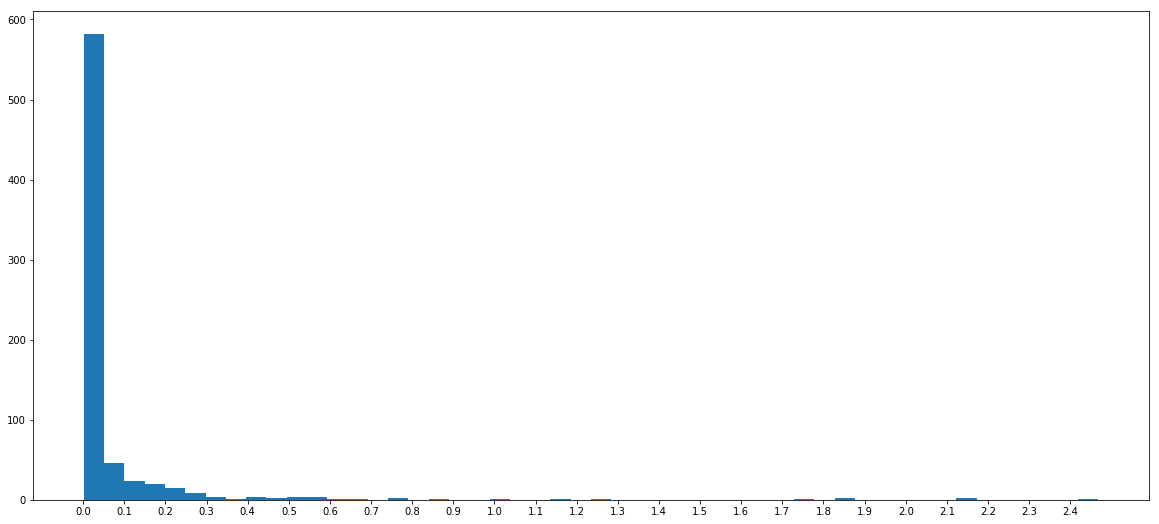

In [77]:
vect = CountVectorizer(lowercase = False)
AllTags = vect.fit_transform(artists['Tags'].values.astype('U'))
asanalysis = pd.DataFrame(index = artists['Artist'] , columns = vect.get_feature_names() , data = AllTags.toarray())
counts = np.array([asanalysis[i].sum()/len(vect.get_feature_names()) for i in asanalysis.columns])
print('max count number :' , counts.max())
plt.figure(figsize = (20,9))
plt.xticks(np.arange(0,2.5,0.1))
plt.hist(counts , bins = 50)
plt.show()


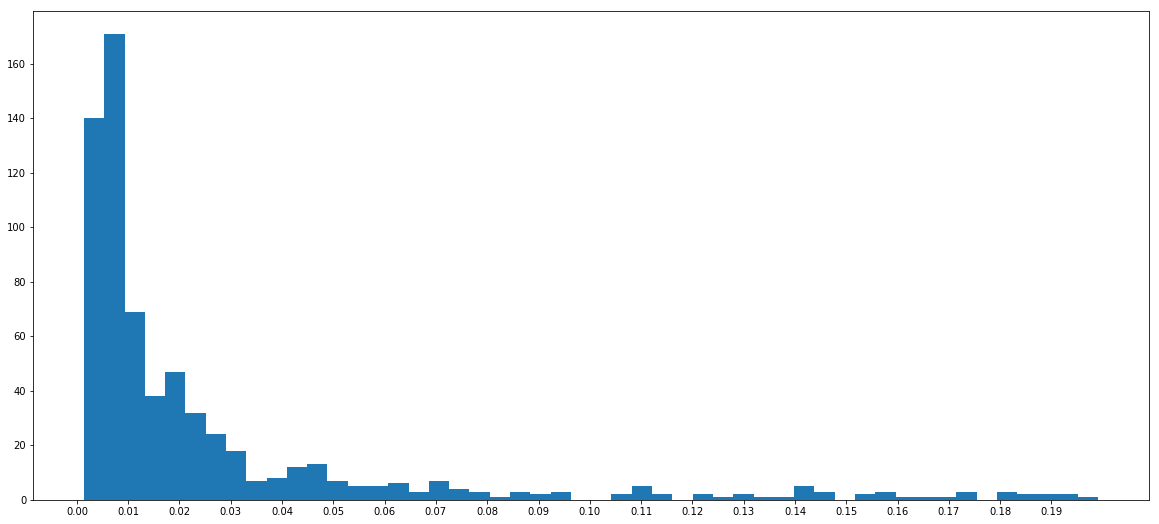

In [78]:
#Will Focus on the small counts as they have the biggest number:
smallcounts=np.array([i for i in counts if i < 0.2])
plt.figure(figsize = (20,9))
plt.xticks(np.arange(0,0.2,0.01))

plt.hist(smallcounts , bins = 50)
plt.show()

Will split my analysis into three parts:
 * small support number,
 *  0.003 support, high lift and confidence
 * bigger support number, smaller confidence

In [79]:
#Replacing with True and False to run apriori:
asanalysis = asanalysis.replace(0 , False).replace(1 , True)
try_apriori = apriori(asanalysis , min_support = 0.05 , use_colnames = True,)
rules = association_rules(try_apriori , metric = "confidence" , min_threshold = 0.7)
rules = rules.sort_values('lift', ascending = False)
rules


antecedents consequents  antecedent support  consequent support  support  \
0       (Rap)    (Hiphop)              0.0846              0.1336     0.08   

   confidence      lift  leverage  conviction  
0    0.945626  7.078042  0.068697   15.934226

In [80]:
#Replacing with True and False to run apriori:
asanalysis = asanalysis.replace(0 , False).replace(1 , True)
try_apriori = apriori(asanalysis , min_support = 0.008 , use_colnames = True,)
rules = association_rules(try_apriori , metric = "confidence", min_threshold = 0.7)
rules = rules.sort_values('lift' , ascending = False)
rules

antecedents     consequents  antecedent support  \
17                          (Kpop)          (KPop)              0.0091   
16                        (Korean)          (KPop)              0.0146   
15                          (KPop)        (Korean)              0.0160   
1                            (Mpb)  (Brazilianian)              0.0106   
18                      (PunkRock)          (Punk)              0.0132   
32                     (Uk, Indie)          (Usaa)              0.0113   
20                          (Usaa)            (Uk)              0.0355   
31                   (Usaa, Indie)            (Uk)              0.0106   
21                            (Uk)          (Usaa)              0.0395   
3                      (DeepHouse)         (House)              0.0100   
29             (UndergroundHiphop)   (Hiphop, Rap)              0.0121   
27     (Hiphop, UndergroundHiphop)           (Rap)              0.0117   
19             (UndergroundHiphop)           (Rap)              0.0121   
25                  (Trap, Hiphop)           (Rap)              0.0135   
28        (Rap, UndergroundHiphop)        (Hiphop)              0.0106   
12             (UndergroundHiphop)        (Hiphop)              0.0121   
26                     (Trap, Rap)        (Hiphop)              0.0118   
11                           (Rap)        (Hiphop)              0.0846   
22  (AlternativeRock, Alternative)          (Rock)              0.0178   
0                (AlternativeRock)          (Rock)              0.0300   
2                    (ClassicRock)          (Rock)              0.0311   
9                       (HardRock)          (Rock)              0.0199   
10            (InstrumentalHiphop)        (Hiphop)              0.0113   
30           (SeenLive, IndieRock)         (Indie)              0.0241   
23        (IndieRock, Alternative)         (Indie)              0.0107   
14                     (IndieRock)         (Indie)              0.0493   
5                        (Electro)   (Electronica)              0.0138   
13                      (IndiePop)         (Indie)              0.0382   
6                   (Electronicaa)   (Electronica)              0.0126   
4                        (Dubstep)   (Electronica)              0.0147   
7                          (House)   (Electronica)              0.0365   
24                  (House, Dance)   (Electronica)              0.0117   
8                         (Techno)   (Electronica)              0.0154   

    consequent support  support  confidence       lift  leverage  conviction  
17              0.0160   0.0089    0.978022  61.126374  0.008754   44.772000  
16              0.0160   0.0128    0.876712  54.794521  0.012566    7.981333  
15              0.0146   0.0128    0.800000  54.794521  0.012566    4.927000  
1               0.0226   0.0086    0.811321  35.899148  0.008360    5.180220  
18              0.0247   0.0105    0.795455  32.204637  0.010174    4.768133  
32              0.0355   0.0106    0.938053  26.424031  0.010199   15.569786  
20              0.0395   0.0355    1.000000  25.316456  0.034098         inf  
31              0.0395   0.0106    1.000000  25.316456  0.010181         inf  
21              0.0355   0.0355    0.898734  25.316456  0.034098    9.524437  
3               0.0365   0.0083    0.830000  22.739726  0.007935    5.667647  
29              0.0800   0.0105    0.867769  10.847107  0.009532    6.957500  
27              0.0846   0.0105    0.897436  10.607989  0.009510    8.925150  
19              0.0846   0.0106    0.876033  10.355001  0.009576    7.384227  
25              0.0846   0.0113    0.837037   9.894055  0.010158    5.617227  
28              0.1336   0.0105    0.990566   7.414416  0.009084   91.838400  
12              0.1336   0.0117    0.966942   7.237591  0.010083   26.208600  
26              0.1336   0.0113    0.957627   7.167868  0.009724   20.447040  
11              0.1336   0.0800    0.945626   7.078042  0.068697   15.934226  
22   

In [81]:
#Replacing with True and False to run apriori:
asanalysis = asanalysis.replace(0 , False).replace(1 , True)
try_apriori = apriori(asanalysis, min_support = 0.001 , use_colnames = True,)
rules = association_rules(try_apriori, metric = "confidence", min_threshold=0.7)
rules = rules.sort_values('lift' , ascending = False)
rules

antecedents  \
56                            (MathMetal)   
713                 (SymphonicMetal, God)   
731                 (SymphonicMetal, God)   
820  (SymphonicMetal, GothicicMetal, God)   
821                 (Goa, SymphonicMetal)   
..                                    ...   
335                       (Dance, Techno)   
83                               (Trance)   
397                (Electropop, Synthpop)   
84                            (Vaporwave)   
76                        (MinimalTechno)   

                                  consequents  antecedent support  \
56                                    (Djent)              0.0013   
713                 (Goa, FemaleFrontedMetal)              0.0015   
731       (FemaleFrontedMetal, GothicicMetal)              0.0015   
820                 (Goa, FemaleFrontedMetal)              0.0015   
821  (FemaleFrontedMetal, GothicicMetal, God)              0.0015   
..                                        ...                 ...   
335                             (Electronica)              0.0026   
83                              (Electronica)              0.0102   
397                             (Electronica)              0.0024   
84                              (Electronica)              0.0017   
76                              (Electronica)              0.0040   

     consequent support  support  confidence        lift  leverage  conviction  
56               0.0017   0.0011    0.846154  497.737557  0.001098    6.488950  
713              0.0016   0.0011    0.733333  458.333333  0.001098    3.744000  
731              0.0016   0.0011    0.733333  458.333333  0.001098    3.744000  
820              0.0016   0.0011    0.733333  458.333333  0.001098    3.744000  
821              0.0016   0.0011    0.733333  458.333333  0.001098    3.744000  
..                  ...      ...         ...         ...       ...         ...  
335              0.1797   0.0019    0.730769    4.066607  0.001433    3.046829  
83               0.1797   0.0074    0.725490    4.037230  0.005567    2.988236  
397              0.1797   0.0017    0.708333    3.941755  0.001269    2.812457  
84               0.1797   0.0012    0.705882    3.928115  0.000895    2.789020  
76               0.1797   0.0028    0.700000    3.895381  0.002081    2.734333  

[838 rows x 9 columns]

In [82]:
#Replacing with True and False to run apriori:
asanalysis = asanalysis.replace(0 , False).replace(1 , True)
try_apriori = apriori(asanalysis, min_support = 0.005 , use_colnames = True,)
rules = association_rules(try_apriori, metric = "confidence", min_threshold = 0.7)
rules = rules.sort_values('lift' , ascending = False)
rules

antecedents     consequents  antecedent support  consequent support  \
13           (Goa)           (God)              0.0081              0.0080   
14           (God)           (Goa)              0.0080              0.0081   
58          (Kpop)  (KPop, Korean)              0.0091              0.0128   
23          (Kpop)          (KPop)              0.0091              0.0160   
57  (Korean, Kpop)          (KPop)              0.0077              0.0160   
..             ...             ...                 ...                 ...   
38  (House, Dance)   (Electronica)              0.0117              0.1797   
11        (Techno)   (Electronica)              0.0154              0.1797   
3      (DeepHouse)   (Electronica)              0.0100              0.1797   
10       (Minimal)   (Electronica)              0.0080              0.1797   
12        (Trance)   (Electronica)              0.0102              0.1797   

    support  confidence        lift  leverage  conviction  
13   0.0077    0.950617  118.827160  0.007635   20.088000  
14   0.0077    0.962500  118.827160  0.007635   26.450667  
58   0.0075    0.824176   64.388736  0.007384    5.614700  
23   0.0089    0.978022   61.126374  0.008754   44.772000  
57   0.0075    0.974026   60.876623  0.007377   37.884000  
..      ...         ...         ...       ...         ...  
38   0.0089    0.760684    4.233076  0.006798    3.427682  
11   0.0116    0.753247    4.191690  0.008833    3.324374  
3    0.0075    0.750000    4.173623  0.005703    3.281200  
10   0.0060    0.750000    4.173623  0.004562    3.281200  
12   0.0074    0.725490    4.037230  0.005567    2.988236  

[61 rows x 9 columns]

An immidiate observation: 


* When it comes to korean music, genres seem to always go together : Kpop , Krock and Korean, have very high values
* This might be a problem for my recommendation system since when it comes to korean music, it will always propose korean music.
* And vice-versa, it will never propose korean pop songs to pop-song likers since the rule : Korean -> Kpop has huge lift and     support values

Maybe thats a good thing since english pop listeners arent interested in a language they cant follow
 
 Or maybe not? How about gagnam style?
 
 What if we can find the next gagnam style?

**Ι will split "KPop" tag to top new tags: Korean and  Pop.**


* A similar approach will be made towards other languages as well: "Jpop" -> "Japanese" + "Pop" , "FrenchRock" -> "French" + "Rock"

* These songs are still considered Rock or Pop songs.

**Having another langunage than English is just another Tag!**

Moreover, some other merged tags like "IndustrialPop" , which follow a same pattern, will also be explored


I will also remove the "SeenLive" tag since it is obvious that is completely useless.

In [83]:
#Lowest thresshold , my dataset is huge so having low support doesnt mean that we cant consider a rule
#Maybe here I can find the best insights:

#I am turning the confidence threshold up 
asanalysis = asanalysis.replace(0 , False).replace(1 , True)
try_apriori = apriori(asanalysis , min_support = 0.002 , use_colnames = True,)
rules = association_rules(try_apriori, metric = "confidence", min_threshold = 0.85)
rules = rules.sort_values('lift' , ascending = False)
rules

antecedents           consequents  antecedent support  \
146                (Russiann, Rock)        (RussiannRock)              0.0020   
160               (Goa, God, Metal)       (GothicicMetal)              0.0022   
113                    (Goa, Metal)       (GothicicMetal)              0.0022   
164                    (God, Metal)  (Goa, GothicicMetal)              0.0022   
116                    (God, Metal)       (GothicicMetal)              0.0022   
..                              ...                   ...                 ...   
67                   (Ambient, Idm)         (Electronica)              0.0031   
16                        (Electro)         (Electronica)              0.0138   
79                 (Dance, Electro)         (Electronica)              0.0029   
156  (TripHop, Downtempo, Chillout)         (Electronica)              0.0026   
18                      (Synthwave)         (Electronica)              0.0050   

     consequent support  support  confidence        lift  leverage  conviction  
146              0.0028   0.0020    1.000000  357.142857  0.001994         inf  
160              0.0034   0.0021    0.954545  280.748663  0.002093   21.925200  
113              0.0034   0.0021    0.954545  280.748663  0.002093   21.925200  
164              0.0034   0.0021    0.954545  280.748663  0.002093   21.925200  
116              0.0034   0.0021    0.954545  280.748663  0.002093   21.925200  
..                  ...      ...         ...         ...       ...         ...  
67               0.1797   0.0028    0.903226    5.026298  0.002243    8.476433  
16               0.1797   0.0124    0.898551    5.000282  0.009920    8.085814  
79               0.1797   0.0026    0.896552    4.989158  0.002079    7.929567  
156              0.1797   0.0023    0.884615    4.922734  0.001833    7.109267  
18               0.1797   0.0044    0.880000    4.897051  0.003502    6.835833  

[172 rows x 9 columns]

Some more insights:

"Russian" + "Rock" => "RussianRock" ,similar with the rule I defined before

"JazzPiano" will be splitted to "jazz" + "piano" ,as a piano lover will like piano in other music genres similar to Jazz , not just Jazz

"Retrowave" seems to be very close to "Synthwave" , however when "Retrowave" is paired with "Electronic" it  gives "Synthwave"

So:

"Retrowave" + "Electronic" => "Synthwave"


Checking the rules even more:


In [84]:
rules[5:]

antecedents           consequents  antecedent support  \
162                    (Goa, Metal)  (GothicicMetal, God)              0.0022   
136                     (JazzPiano)         (Piano, Jazz)              0.0025   
89         (Retrowave, Electronica)           (Synthwave)              0.0020   
45                      (Retrowave)           (Synthwave)              0.0025   
66                     (Background)      (Ambient, Piano)              0.0022   
..                              ...                   ...                 ...   
67                   (Ambient, Idm)         (Electronica)              0.0031   
16                        (Electro)         (Electronica)              0.0138   
79                 (Dance, Electro)         (Electronica)              0.0029   
156  (TripHop, Downtempo, Chillout)         (Electronica)              0.0026   
18                      (Synthwave)         (Electronica)              0.0050   

     consequent support  support  confidence        lift  leverage  conviction  
162              0.0034   0.0021    0.954545  280.748663  0.002093   21.925200  
136              0.0047   0.0025    1.000000  212.765957  0.002488         inf  
89               0.0050   0.0020    1.000000  200.000000  0.001990         inf  
45               0.0050   0.0024    0.960000  192.000000  0.002387   24.875000  
66               0.0061   0.0021    0.954545  156.482861  0.002087   21.865800  
..                  ...      ...         ...         ...       ...         ...  
67               0.1797   0.0028    0.903226    5.026298  0.002243    8.476433  
16               0.1797   0.0124    0.898551    5.000282  0.009920    8.085814  
79               0.1797   0.0026    0.896552    4.989158  0.002079    7.929567  
156              0.1797   0.0023    0.884615    4.922734  0.001833    7.109267  
18               0.1797   0.0044    0.880000    4.897051  0.003502    6.835833  

[167 rows x 9 columns]

In [85]:
rules[15:]

antecedents    consequents  antecedent support  \
108                   (GothicicRock, Goa)          (God)              0.0021   
105                  (Goa, GothicicMetal)          (God)              0.0034   
102                       (Goa, Gothicic)          (God)              0.0034   
30                         (GothicicRock)          (God)              0.0021   
158  (MinimalTechno, Electronica, Techno)      (Minimal)              0.0021   
..                                    ...            ...                 ...   
67                         (Ambient, Idm)  (Electronica)              0.0031   
16                              (Electro)  (Electronica)              0.0138   
79                       (Dance, Electro)  (Electronica)              0.0029   
156        (TripHop, Downtempo, Chillout)  (Electronica)              0.0026   
18                            (Synthwave)  (Electronica)              0.0050   

     consequent support  support  confidence        lift  leverage  conviction  
108              0.0080   0.0021    1.000000  125.000000  0.002083         inf  
105              0.0080   0.0034    1.000000  125.000000  0.003373         inf  
102              0.0080   0.0034    1.000000  125.000000  0.003373         inf  
30               0.0080   0.0021    1.000000  125.000000  0.002083         inf  
158              0.0080   0.0021    1.000000  125.000000  0.002083         inf  
..                  ...      ...         ...         ...       ...         ...  
67               0.1797   0.0028    0.903226    5.026298  0.002243    8.476433  
16               0.1797   0.0124    0.898551    5.000282  0.009920    8.085814  
79               0.1797   0.0026    0.896552    4.989158  0.002079    7.929567  
156              0.1797   0.0023    0.884615    4.922734  0.001833    7.109267  
18               0.1797   0.0044    0.880000    4.897051  0.003502    6.835833  

[157 rows x 9 columns]

In [86]:
#Backround->Ambient

In [87]:
rules[30:40]


antecedents     consequents  antecedent support  \
109               (GothicicRock, God)           (Goa)              0.0021   
26                    (GothicicMetal)           (Goa)              0.0034   
25                         (Gothicic)           (Goa)              0.0034   
161       (GothicicMetal, Metal, God)           (Goa)              0.0021   
14                       (DrumsNBass)  (DrumsAndBass)              0.0021   
23                              (Goa)           (God)              0.0081   
24                              (God)           (Goa)              0.0080   
13                              (Dnb)  (DrumsAndBass)              0.0036   
141           (MinimalTechno, Techno)       (Minimal)              0.0032   
88   (Electronica, ProgressiveTrance)        (Trance)              0.0020   

     consequent support  support  confidence        lift  leverage  conviction  
109              0.0081   0.0021    1.000000  123.456790  0.002083         inf  
26               0.0081   0.0034    1.000000  123.456790  0.003372         inf  
25               0.0081   0.0034    1.000000  123.456790  0.003372         inf  
161              0.0081   0.0021    1.000000  123.456790  0.002083         inf  
14               0.0078   0.0020    0.952381  122.100122  0.001984   20.836200  
23               0.0080   0.0077    0.950617  118.827160  0.007635   20.088000  
24               0.0081   0.0077    0.962500  118.827160  0.007635   26.450667  
13               0.0078   0.0032    0.888889  113.960114  0.003172    8.929800  
141              0.0080   0.0028    0.875000  109.375000  0.002774    7.936000  
88               0.0102   0.0020    1.000000   98.039216  0.001980         inf

In [88]:
rules[50:60]


antecedents consequents  antecedent support  \
8                          (ModernCountry)   (Country)              0.0022   
5                         (ClassicCountry)   (Country)              0.0024   
157  (Minimal, MinimalTechno, Electronica)    (Techno)              0.0022   
40                                  (Kpop)      (KPop)              0.0091   
138                          (Pop, Korean)      (KPop)              0.0039   
137                         (Korean, Kpop)      (KPop)              0.0077   
139                            (Pop, Kpop)      (KPop)              0.0033   
140               (Minimal, MinimalTechno)    (Techno)              0.0030   
171                    (Pop, Korean, Kpop)      (KPop)              0.0023   
39                                (Korean)      (KPop)              0.0146   

     consequent support  support  confidence       lift  leverage  conviction  
8                0.0161   0.0022    1.000000  62.111801  0.002165         inf  
5                0.0161   0.0024    1.000000  62.111801  0.002361         inf  
157              0.0154   0.0021    0.954545  61.983471  0.002066   21.661200  
40               0.0160   0.0089    0.978022  61.126374  0.008754   44.772000  
138              0.0160   0.0038    0.974359  60.897436  0.003738   38.376000  
137              0.0160   0.0075    0.974026  60.876623  0.007377   37.884000  
139              0.0160   0.0032    0.969697  60.606061  0.003147   32.472000  
140              0.0154   0.0028    0.933333  60.606061  0.002754   14.769000  
171              0.0160   0.0022    0.956522  59.782609  0.002163   22.632000  
39               0.0160   0.0128    0.876712  54.794521  0.012566    7.981333

In [89]:
rules[70:80]

antecedents        consequents  antecedent support  \
53                (Rock, 70S)      (ClassicRock)              0.0053   
150  (Alternative, Rock, 90S)  (AlternativeRock)              0.0027   
0                (PostGrunge)  (AlternativeRock)              0.0023   
56             (NewWave, Pop)             (80SS)              0.0061   
86             (DreamPop, Uk)             (Usaa)              0.0025   
93         (Experimental, Uk)             (Usaa)              0.0025   
75                (Uk, Chill)             (Usaa)              0.0035   
143         (Psychedelic, Uk)             (Usaa)              0.0021   
129            (Uk, IndiePop)             (Usaa)              0.0040   
166     (Indie, Uk, IndiePop)             (Usaa)              0.0022   

     consequent support  support  confidence       lift  leverage  conviction  
53               0.0311   0.0051    0.962264  30.940969  0.004935   25.675850  
150              0.0300   0.0025    0.925926  30.864198  0.002419   13.095000  
0                0.0300   0.0020    0.869565  28.985507  0.001931    7.436667  
56               0.0324   0.0057    0.934426  28.840316  0.005502   14.755900  
86               0.0355   0.0025    1.000000  28.169014  0.002411         inf  
93               0.0355   0.0025    1.000000  28.169014  0.002411         inf  
75               0.0355   0.0035    1.000000  28.169014  0.003376         inf  
143              0.0355   0.0021    1.000000  28.169014  0.002025         inf  
129              0.0355   0.0040    1.000000  28.169014  0.003858         inf  
166              0.0355   0.0022    1.000000  28.169014  0.002122         inf

**Some more rules**

"ChansonFrancaise" -> "French"

"Dnb"- "DrumsAndBass" eems to be the exact same thing

"DrumsNBass" => "DrumsAndBass" as well.

This "DrumsAndBass" rule got me thinking that maybe some tags have different names , while they are the same.
**Will explore that even further**


Checking the length of the unique tags:

In [90]:

asd=artists['Tags'].str.split(',').tolist()
def flat(l):
    def _flat(l, r):    
        if type(l) is not list:
            r.append(l)
        else:
            for i in l:
                r = r + flat(i)
        return r
    return _flat(l, [])
len(np.unique(flat(asd)) )

732

**Another insight which was discovered was that some tags were the consequent in many association rules**

This produced an idea that an hierarchy of Classes could be designed were the antecedents of the rules would be under the consequent in a potential hierarchy

**To validate my approach Tf-IDF was used to calculate the importance(strenght) of the higher in the hierarchy classes**

In [91]:
#How improtant is every genre to a band
tf = TfidfVectorizer(lowercase = False)
ab = tf.fit_transform(artists['Tags'].values.astype('U'))
test = pd.DataFrame(index = artists['Artist'] , columns = tf.get_feature_names() , data = ab.toarray())
test.loc['Sums'] = test.sum(axis = 0)
test

40S       50S        60S       70S       80S  \
Artist                                                                  
Kanye West          0.000000  0.000000   0.000000   0.00000  0.000000   
Billie Eilish       0.000000  0.000000   0.000000   0.00000  0.000000   
Post Malone         0.000000  0.000000   0.000000   0.00000  0.000000   
Ariana Grande       0.000000  0.000000   0.000000   0.00000  0.000000   
Coldplay            0.000000  0.000000   0.000000   0.00000  0.000000   
...                      ...       ...        ...       ...       ...   
Wim Mertens         0.000000  0.000000   0.000000   0.00000  0.000000   
The Seeds           0.000000  0.000000   0.482469   0.00000  0.000000   
The Appleseed Cast  0.000000  0.000000   0.000000   0.00000  0.000000   
Brand Nubian        0.000000  0.000000   0.000000   0.00000  0.000000   
Sums                2.755141  8.934173  72.056145  65.22999  0.875136   

                          80SS      8Bit        90S  ACappella  \
Artist                                                           
Kanye West            0.000000  0.000000   0.000000   0.000000   
Billie Eilish         0.000000  0.000000   0.000000   0.000000   
Post Malone           0.000000  0.000000   0.000000   0.000000   
Ariana Grande         0.000000  0.000000   0.000000   0.000000   
Coldplay              0.000000  0.000000   0.000000   0.000000   
...                        ...       ...        ...        ...   
Wim Mertens           0.000000  0.000000   0.000000   0.000000   
The Seeds             0.000000  0.000000   0.000000   0.000000   
The Appleseed Cast    0.000000  0.000000   0.000000   0.000000   
Brand Nubian          0.000000  0.000000   0.000000   0.000000   
Sums                161.187353  7.373547  70.106368   3.497012   

                    AbstractHiphop  ...  WitchHouse   Wonky      World  \
Artist                              ...                                  
Kanye West                0.000000  ...     0.00000  0.0000   0.000000   
Billie Eilish             0.000000  ...     0.00000  0.0000   0.000000   
Post Malone               0.000000  ...     0.00000  0.0000   0.000000   
Ariana Grande             0.000000  ...     0.00000  0.0000   0.000000   
Coldplay                  0.000000  ...     0.00000  0.0000   0.000000   
...                            ...  ...         ...     ...        ...   
Wim Mertens               0.000000  ...     0.00000  0.0000   0.000000   
The Seeds                 0.000000  ...     0.00000  0.0000   0.000000   
The Appleseed Cast        0.000000  ...     0.00000  0.0000   0.000000   
Brand Nubian              0.000000  ...     0.00000  0.0000   0.000000   
Sums                      5.432664  ...    10.35133  8.8145  12.582681   

                    WorldMusic   Worship    WuTang   XFactor  Youngstar  \
Artist                                                                    
Kanye West            0.000000  0.000000  0.000000  0.000000   0.000000   
Billie Eilish         0.000000  0.000000  0.000000  0.000000   0.000000   
Post Malone           0.000000  0.000000  0.000000  0.000000   0.000000   
Ariana Grande         0.000000  0.000000  0.000000  0.000000   0.000000   
Coldplay              0.000000  0.000000  0.000000  0.000000   0.000000   
...                        ...       ...       ...       ...        ...   
Wim Mertens           0.000000  0.000000  0.000000  0.000000   0.000000   
The Seeds             0.000000  0.000000  0.000000  0.000000   0.000000   
The Appleseed Cast    0.000000  0.000000  0.000000  0.000000   0.000000   
Brand Nubian          0.000000  0.000000  0.000000  0.000000   0.000000   
Sums                  1.110181  5.542228  6.514119  3.075572   1.769822   

                     Youtube    nan  
Artist                               
Kanye West          0.000000    0.0  
Billie Eilish       0.000000    0.0  
Post Malone         0.000000    0.0  
Ariana Grande       0.000000    0.0  
Coldplay            0.000000    0.0  
...        

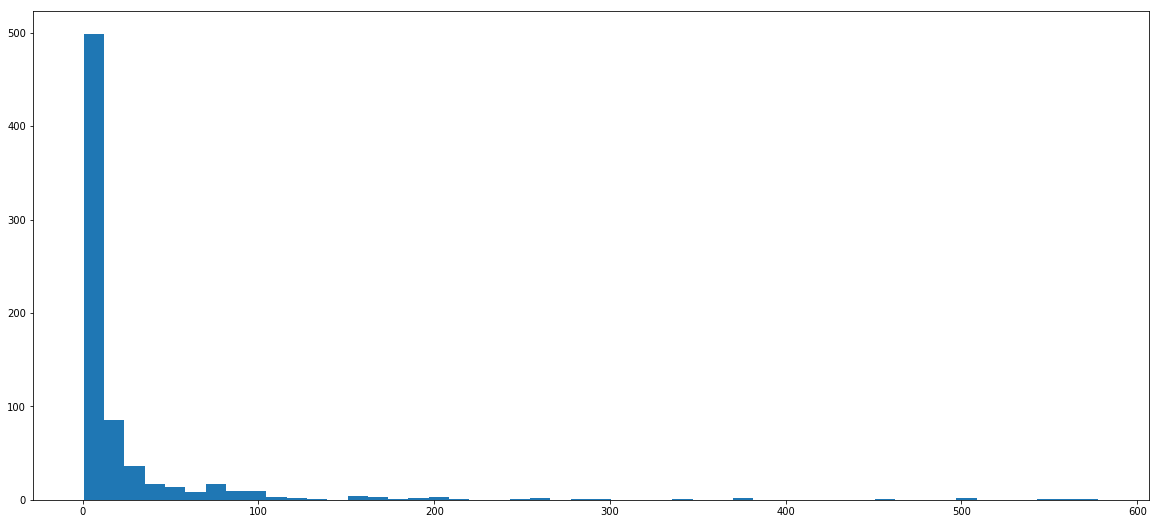

In [92]:
#Lets examine the "sums" column a bit:
plt.figure(figsize = (20,9))

plt.hist(test.loc['Sums'] , bins = 50)

plt.show()


There are some tags which are very "Strong" for their respective bands

These tags Will be considered **Superclasses**


In [93]:
test = test.transpose()
z = test[test['Sums'] > 450]
z

Artist       Kanye West  Billie Eilish  Post Malone  Ariana Grande  Coldplay  \
Electronica    0.000000       0.415785     0.000000       0.000000  0.000000   
Hiphop         0.484098       0.000000     0.331041       0.000000  0.000000   
Indie          0.000000       0.435960     0.000000       0.000000  0.000000   
Pop            0.000000       0.459655     0.000000       0.486626  0.000000   
Rock           0.000000       0.000000     0.000000       0.000000  0.343269   
SeenLive       0.000000       0.000000     0.000000       0.000000  0.000000   

Artist       Lana Del Rey  Tame Impala    Queen  Ed Sheeran  The Beatles  ...  \
Electronica      0.000000     0.000000  0.00000         0.0     0.000000  ...   
Hiphop           0.000000     0.000000  0.00000         0.0     0.000000  ...   
Indie            0.416561     0.000000  0.00000         0.0     0.000000  ...   
Pop              0.439202     0.000000  0.00000         0.0     0.000000  ...   
Rock             0.000000     0.000000  0.35873         0.0     0.351182  ...   
SeenLive         0.000000     0.312874  0.00000         0.0     0.000000  ...   

Artist       W00DS    Datsik  Jerry Douglas   Lo Moon  Kronos Quartet  \
Electronica    0.0  0.218237            0.0  0.409621             0.0   
Hiphop         0.0  0.000000            0.0  0.000000             0.0   
Indie          0.0  0.000000            0.0  0.429496             0.0   
Pop            0.0  0.000000            0.0  0.000000             0.0   
Rock           0.0  0.000000            0.0  0.000000             0.0   
SeenLive       0.0  0.000000            0.0  0.431810             0.0   

Artist       Wim Mertens  The Seeds  The Appleseed Cast  Brand Nubian  \
Electronica          0.0        0.0            0.000000      0.000000   
Hiphop               0.0        0.0            0.000000      0.424577   
Indie                0.0        0.0            0.314454      0.000000   
Pop                  0.0        0.0            0.000000      0.000000   
Rock                 0.0        0.0            0.000000      0.000000   
SeenLive             0.0        0.0            0.000000      0.000000   

Artist             Sums  
Electronica  559.212408  
Hiphop       500.861196  
Indie        577.898429  
Pop          499.584221  
Rock         452.577163  
SeenLive     549.476973  

[6 rows x 10001 columns]

In [94]:
z = test[(test['Sums'] < 50)]
z

Artist     Kanye West  Billie Eilish  Post Malone  Ariana Grande  Coldplay  \
40S               0.0            0.0          0.0            0.0       0.0   
50S               0.0            0.0          0.0            0.0       0.0   
80S               0.0            0.0          0.0            0.0       0.0   
8Bit              0.0            0.0          0.0            0.0       0.0   
ACappella         0.0            0.0          0.0            0.0       0.0   
...               ...            ...          ...            ...       ...   
Worship           0.0            0.0          0.0            0.0       0.0   
WuTang            0.0            0.0          0.0            0.0       0.0   
XFactor           0.0            0.0          0.0            0.0       0.0   
Youngstar         0.0            0.0          0.0            0.0       0.0   
Youtube           0.0            0.0          0.0            0.0       0.0   

Artist     Lana Del Rey  Tame Impala  Queen  Ed Sheeran  The Beatles  ...  \
40S                 0.0          0.0    0.0         0.0          0.0  ...   
50S                 0.0          0.0    0.0         0.0          0.0  ...   
80S                 0.0          0.0    0.0         0.0          0.0  ...   
8Bit                0.0          0.0    0.0         0.0          0.0  ...   
ACappella           0.0          0.0    0.0         0.0          0.0  ...   
...                 ...          ...    ...         ...          ...  ...   
Worship             0.0          0.0    0.0         0.0          0.0  ...   
WuTang              0.0          0.0    0.0         0.0          0.0  ...   
XFactor             0.0          0.0    0.0         0.0          0.0  ...   
Youngstar           0.0          0.0    0.0         0.0          0.0  ...   
Youtube             0.0          0.0    0.0         0.0          0.0  ...   

Artist     W00DS  Datsik  Jerry Douglas  Lo Moon  Kronos Quartet  Wim Mertens  \
40S          0.0     0.0            0.0      0.0             0.0          0.0   
50S          0.0     0.0            0.0      0.0             0.0          0.0   
80S          0.0     0.0            0.0      0.0             0.0          0.0   
8Bit         0.0     0.0            0.0      0.0             0.0          0.0   
ACappella    0.0     0.0            0.0      0.0             0.0          0.0   
...          ...     ...            ...      ...             ...          ...   
Worship      0.0     0.0            0.0      0.0             0.0          0.0   
WuTang       0.0     0.0            0.0      0.0             0.0          0.0   
XFactor      0.0     0.0            0.0      0.0             0.0          0.0   
Youngstar    0.0     0.0            0.0      0.0             0.0          0.0   
Youtube      0.0     0.0            0.0      0.0             0.0          0.0   

Artist     The Seeds  The Appleseed Cast  Brand Nubian      Sums  
40S              0.0                 0.0           0.0  2.755141  
50S              0.0                 0.0           0.0  8.934173  
80S              0.0                 0.0           0.0  0.875136  
8Bit             0.0                 0.0           0.0  7.373547  
ACappella        0.0                 0.0           0.0  3.497012  
...              ...                 ...           ...       ...  
Worship          0.0                 0.0           0.0  5.542228  
WuTang           0.0                 0.0           0.0  6.514119  
XFactor          0.0                 0.0           0.0  3.075572  
Youngstar        0.0                 0.0           0.0  1.769822  
Youtube          0.0                 0.0           0.0  3.560631  

[639 rows x 10001 columns]

In [95]:
zz = test[(test['Sums'] < 450) & (test['Sums'] > 50)]
zz

Artist             Kanye West  Billie Eilish  Post Malone  Ariana Grande  \
60S                       0.0            0.0          0.0            0.0   
70S                       0.0            0.0          0.0            0.0   
80SS                      0.0            0.0          0.0            0.0   
90S                       0.0            0.0          0.0            0.0   
Acoustic                  0.0            0.0          0.0            0.0   
...                       ...            ...          ...            ...   
TripHop                   0.0            0.0          0.0            0.0   
Uk                        0.0            0.0          0.0            0.0   
UndergroundHiphop         0.0            0.0          0.0            0.0   
Usaa                      0.0            0.0          0.0            0.0   
nan                       0.0            0.0          0.0            0.0   

Artist             Coldplay  Lana Del Rey  Tame Impala     Queen  Ed Sheeran  \
60S                     0.0           0.0          0.0  0.000000    0.000000   
70S                     0.0           0.0          0.0  0.000000    0.000000   
80SS                    0.0           0.0          0.0  0.517787    0.000000   
90S                     0.0           0.0          0.0  0.000000    0.000000   
Acoustic                0.0           0.0          0.0  0.000000    0.473472   
...                     ...           ...          ...       ...         ...   
TripHop                 0.0           0.0          0.0  0.000000    0.000000   
Uk                      0.0           0.0          0.0  0.000000    0.000000   
UndergroundHiphop       0.0           0.0          0.0  0.000000    0.000000   
Usaa                    0.0           0.0          0.0  0.000000    0.000000   
nan                     0.0           0.0          0.0  0.000000    0.000000   

Artist             The Beatles  ...     W00DS  Datsik  Jerry Douglas  Lo Moon  \
60S                   0.608345  ...  0.000000     0.0       0.000000      0.0   
70S                   0.000000  ...  0.000000     0.0       0.000000      0.0   
80SS                  0.000000  ...  0.000000     0.0       0.000000      0.0   
90S                   0.000000  ...  0.000000     0.0       0.000000      0.0   
Acoustic              0.000000  ...  0.000000     0.0       0.525371      0.0   
...                        ...  ...       ...     ...            ...      ...   
TripHop               0.000000  ...  0.000000     0.0       0.000000      0.0   
Uk                    0.000000  ...  0.393947     0.0       0.000000      0.0   
UndergroundHiphop     0.000000  ...  0.000000     0.0       0.000000      0.0   
Usaa                  0.000000  ...  0.403866     0.0       0.000000      0.0   
nan                   0.000000  ...  0.000000     0.0       0.000000      0.0   

Artist             Kronos Quartet  Wim Mertens  The Seeds  The Appleseed Cast  \
60S                           0.0          0.0   0.482469                 0.0   
70S                           0.0          0.0   0.000000                 0.0   
80SS                          0.0          0.0   0.000000                 0.0   
90S                           0.0          0.0   0.000000                 0.0   
Acoustic                      0.0          0.0   0.000000                 0.0   
...                           ...          ...        ...                 ...   
TripHop                       0.0          0.0   0.000000                 0.0   
Uk                            0.0          0.0   0.000000                 0.0   
UndergroundHiphop             0.0          0.0   0.000000                 0.0   
Usaa                          0.0          0.0   0.000000                 0.0   
nan                           0.0          0.0   0.000000                 0.0   

Artist             Brand Nubian        Sums  
60S                    0.000000   72.056145  
70S                    0.000000   65.229990  
80SS                   0.000000  161.18735

I can understand that tags are separated into 3 hierarchical classes
 * First the **Superclass** music genre , with sum of weights over 450
 * Second a **subclass** of the music genre (weights between 450 and 50). My idea is to focus o this class and make it's sample size even bigger
 * Third a **specific property** about an artist, which can rarely be found among other artists.


Some examples of this hierarchy:

* PostRock and AlternativeElectronic
 * Both these two tags contain a superclass: Rock and Electronic
 * They also contain a tag on the second subclass: Post and Alternative 
* Another Example is PunkRock and IndustrialRock

### 2.5 **This is my next Rule**:

Will split all the subclasses(ig IndustricalRock->Industrial+Rock , so instead of having 2 subclasses of Rock(IndustrialRock and Industrial) , I will only have one (Industrial) combined with the Superclass Rock)
This way the total number of tags will be reduced and better simillarity scores among artists will be achieved:

**Note**
I have only splitted tags where both of the two resulted ones were included in the initial list of tags.
* I didnt splitted some tags like PostRock PostMetal because they are veru specific music genres

* The next rule is: Identical tags that have the same meaning but are spelled differentely, (ig for example Uk and England , or Drums&bass and DrumsAndBase)

* Will also remove useles tags such as SeenLive,Shit Music etc

* And will use my music experience for some more changes:

The applied set of rules:

### 2.6 Fifth Approach
#### My Experience

After examining the remaining tags I removed the insignificant ones and replaced some tags that had the same meaning based on my music experience

In [96]:
#Total changes after association analysis:
#Along with some splits
to_change=['Dnb','DrumsNBass','ChansonFrancaise','Background','KPop','Kpop','SeenLive','Jpop','Jrock','Drums&Bass',"Drums'N'Bass",'Amazing',
           'AmericanaIdol','Americanaa','Americana','Australiann','Awesome','BestOf2017','Beatss','BetterThanSelenaGomez','Boyandss','Brazilianian','Coverss',
          'Cubann','FakeMusic','Gay','Germanyy', 'GirlGroupss','Israelii','Jamaicann','Japanese','Latinoo','MusicalsTheatre','MusicalsTheater',
           'MusicalTheatre','MusicalTheatre', 'Musicalss','Norwegian','Polish',
          "R'N'B",'RapFrancais',"Rock'N'Roll",'RockAndRoll','Romanticaa','Sexy', 'Shit','Spanish','Sweden','UnitedKingdom','UnitedStates','Usa','Usaa'
          ,'nan','Jpop','Jrock',"''","80S'S","80SS",'British','Mierda','KanyeWest','Madchester','OneDirection','Philly','R&B','RiotGrrrl','Russiann',
          'Singer/Songwriter','SingerSongwriter','Soundtrackss','SwedishBlackMetal','Sxsw2017','All','Algorithm','Boybandss', 'Electronicaa','England','Electro',
          'Epic','FemaleVocalistss','FemaleFrontedMetal','FemaleRapper','Gothicic','Minimalism','TrailerMusic','VideoGameMusic',
          'WorldMusic','Electronicapop','Electronicanica','MaleVocalistss','Electronicanica','Electronicapop','Hiphop','GuitarVirtuoso',
          'CoolJazz','Americana','Composerss','CoolJazz']

to_=['DrumsAndBass','DrumsAndBass','French','Ambient','Pop','Pop','','Pop','Rock','DrumsAndBass','DrumsAndBass','','','American','American',
    'Australian','','','Beats','','Boybands','Brazilian','Covers','Cuban','','','Germany', 'GirlGroups','Israeli','Jamaican','Japan','Latino',
    'Musicals','Musicals', 'Musicals', 'Musicals', 'Musicals','Norway', 'Poland','Rnb','RapFr','RockNRoll','RockNRoll','Romantica','','','Spain', 'Swedish',
     'Uk','American','American','American','','Pop','Rock',"",'80S','80S','Uk','','','Manchester','','Philadelphia','Rnb','','Russian','Songwriter','Songwriter'
     ,'Soundtracks','','', '','','Boybands', 'Electronica','Uk','Electronica','','FemaleVocalists','FemaleVocalists','FemaleVocalists','Gothic','Minimal',
     'Soundtracks','GameSoundtracks','World','Electronica,Pop','Electronica','MaleVocalists','Electronica','Electronica,Pop','HipHop','','',
    'American','Composers','Jazz']

split=['Synthwave','JazzPiano','RussianRock','BrazilianCountry','BrazilianRock','Britppop','Death/DoomMetal','DeathDoomMetal','PolandRock',
      'PolskiHipHop','PsychedelicPop','PsychedelicRock','RockArgentino','RockBrazilianeiro','RockChileno','RockEnEspanol','RockFrancais',
      'RussianAlternative','RussianRap','RussianRock','SpainIndiePop','SymphonicBlackMetal','SymphonicMetal','TurkishPop','TurkishRock',
      'TrueNorwayBlackMetal','UkBass','UkGarage','UkHipHop','RapFr','PianoRock','BluesRock','ChicagoBlues','ChristianHipHop','ChristianMetalcore',
       'ChristianRap', 'ChristianRock','ElectroPop', 'ElectroSwing', 'Electroclash', 'ElectronicaRock','Electropop','EmoRap',
      'FolkMetal', 'FolkPunk','FolkRock', 'FrenchElectro', 'FrenchHipHop', 'FrenchHouse','FrenchPop', 'FrenchRap', 'FrenchTouch','FunkMetal', 'FunkRock',
      'FutureBass', 'FutureFunk', 'FutureGarage', 'FutureHouse','Futurepop','GaragePunk','GarageRock','GermanyHipHop','GothicMetal', 'GothicRock',
      'HardcoreHipHop','HardcorePunk', 'HardcoreRap','ItalianPop', 'ItaloDisco','JPop', 'JRock','KRnb','JazzFunk','JazzRock'
      , 'LatinoPop', 'LatinoRock', 'LatinoTrap','LatinoUrban',
      'MelodicBlackMetal', 'MelodicDeathMetal', 'MelodicHardcore','MelodicMetal', 'MelodicMetalcore', 'MelodicPunk', 'MelodicRock','MelodicTrance',
       'NoisePop','NoiseRock', 'NordicFolk','NorwayBlackMetal','PhiladelphiaSoul','PianoRock','ProgressiveBlackMetal','ProgressiveDeathMetal',
       'ProgressiveDeathcore','ProgressiveHouse', 'ProgressiveMetal', 'ProgressiveMetalcore','ProgressiveRock','ProgressiveThrashMetal', 'ProgressiveTrance'
      ,'RapNacional', 'RapRock', 'StonerDoom', 'StonerMetal', 'StonerRock','SurfRock', 'SynthRock', 'Synthpop','TrapRap',
      'UkHipHop','UndergroundHipHop', 'UndergroundRap','VocalHouse', 'VocalJazz', 'VocalTrance','WestCoastRap',
      'AlternativeHipHop', 'AlternativeMetal','AlternativePop', 'AlternativeRap', 'AlternativeRnb','AlternativeRock',
      'ElectronicaHouse', 'ElectronicaIndustrial', 'ElectronicaPop','ElectronicaSwing', 'Electronicaclash','ElectronicanicaRock',
       'IndustrialMetal', 'IndustrialRock', 'IndustrialTechno', 'InstrumentalHipHop', 'InstrumentalRock',
      'ModernClassical', 'ModernCountry', 'ModernJazz', 'ModernMetal','ModernRock','Hiphop','Britpop','IndieFolk', 'IndiePop', 'IndieRock', 'Indietronica',
      'ExperimentalHipHop','OldSchoolDeathMetal','ContemporaryChristian','ContemporaryClassical','ContemporaryCountry', 'ContemporaryJazz',
      'CountryPop', 'CountryRock','AvantGardeJazz','AvantGardeMetal']

split_to=['Retrowave,Electronica','Jazz,Piano','Russian,Rock','Brazilian,Country','Brazilian,Rock','Uk,Pop','DeathMetal,DoomMetal','DeathMetal,DoomMetal',
         'Poland,Rock','Poland,HipHop','Psychedelic,Pop','Psychedelic,Rock','Rock,Argentina','Rock,Brazilian','Rock,Chile','Rock,Spain','Rock,French',
         'Russian,Alternative','Russian,Rap','Russian,Rock','Spain,IndiePop','BlackMetal,Symphonic','Symphonic,Metal','Turkish,Pop','Turkish,Rock',
         'BlackMetal,Norway','Uk,Bass','Uk,Garage','Uk,HipHop','Rap,French','Piano,Rock','Blues,Rock','Chicago,Blues','Christian,HipHop','Christian,Metalcore',
       'Christian,Rap', 'Christian,Rock','Electronica,Pop', 'Electronica,Swing', 'Electronica,Clash','Electronica,Rock','Electronica,Pop','Emo,Rap',
         'Folk,Metal', 'Folk,Punk','Folk,Rock', 'French,Electronica', 'French,HipHop', 'French,House','French,Pop', 'French,Rap', 'French,Touch',
         'Funk,Metal', 'Funk,Rock','Future,Bass', 'Future,Funk', 'Future,Garage', 'Future,House','Future,Pop','Garage,Punk','Garage,Rock','Germany,HipHop',
         'Gothic,Metal', 'Gothic,Rock','Hardcore,HipHop','Hardcore,Punk', 'Hardcore,Rap','Italian,Pop', 'Italian,Disco','Japan,Pop', 'Japan,Rock','Korean,Rnb',
         'Jazz,Funk','Jazz,Rock', 'Latino,Pop', 'Latino,Rock', 'Latino,Trap','Latino,Urban',
         'Melodic,BlackMetal', 'Melodic,DeathMetal', 'Melodic,Hardcore','Melodic,Metal', 'Melodic,Metalcore', 'Melodic,Punk', 'Melodic,Rock','Melodic,Trance',
         'Noise,Pop','Noise,Rock', 'Norway,Folk','Norway,BlackMetal','Philadelphia,Soul','Piano,Rock','Progressive,BlackMetal','Progressive,DeathMetal', 
          'Progressive,Deathcore','Progressive,House', 'Progressive,Metal', 'Progressive,Metalcore','Progressive,Rock','Progressive,ThrashMetal'
          , 'Progressive,Trance','Rap,Nacional', 'Rap,Rock', 'Stoner,Doom', 'Stoner,Metal', 'Stoner,Rock','Surf,Rock', 'Synth,Rock', 'Synth,Pop','Trap,Rap',
         'Uk,HipHop','Underground,HipHop', 'Underground,Rap','Vocal,House', 'Vocal,Jazz', 'Vocal,Trance','WestCoast,Rap',
         'Alternative,HipHop', 'Alternative,Metal','Alternative,Pop', 'Alternative,Rap', 'Alternative,Rnb','Alternative,Rock',
         'Electronica,House', 'Electronica,Industrial', 'Electronica,Pop','Electronica,Swing', 'Electronica,Clash', 'Electronica,Rock',
          'Industrial,Metal', 'Industrial,Rock', 'Industrial,Techno', 'Instrumental,HipHop', 'Instrumental,Rock',
         'Modern,Classical', 'Modern,Country', 'Modern,Jazz', 'Modern,Metal','Modern,Rock','HipHop','Uk,Pop','Indie,Folk', 'Indie,Pop', 'Indie,Rock',
          'Indi,Electronica','Experimental,HipHop','OldSchool,DeathMetal','Contemporary,Christian','Contemporary,Classical',
         'Contemporary,Country', 'Contemporary,Jazz','Country,Pop', 'Country,Rock','AvantGarde,Jazz','AvantGarde,Metal']


In [97]:
#I will keep it in another dataframe in case something goes wrong
aa = artists[['Tags']]
#Applying changes:

for i in range(len(to_change)):
        aa['Tags'] = aa['Tags'].str.replace(to_change[i] , to_[i])
        print("\nchange:" , to_change[i])
        print("to" , to_[i])
for i in range(len(split)):
        aa['Tags'] = aa['Tags'].str.replace(split[i] , split_to[i])
        print("\nchange:" , split[i])
        print("to" , split_to[i])
#Getting rid of the double commas that might occur after removing some elements
aa['Tags'] = aa['Tags'].str.replace(',,',',')
#Removing Duplicates:
for i in range(len(aa)):
    if len(aa.iloc[i]['Tags'].split(',')) != len(set(aa.iloc[i]['Tags'].split(','))):
        aa.iloc[i]['Tags'] = ','.join(list(set(aa.iloc[i]['Tags'].split(','))))
            
#If sth goes wrong with these replacments i ill come back here and will change aa insted of the whole artists dataset
artists['Tags'] = aa['Tags']
       
 

D:\aa\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



change: Dnb
to DrumsAndBass

change: DrumsNBass
to DrumsAndBass

change: ChansonFrancaise
to French

change: Background
to Ambient

change: KPop
to Pop

change: Kpop
to Pop

change: SeenLive
to 

change: Jpop
to Pop

change: Jrock
to Rock

change: Drums&Bass
to DrumsAndBass

change: Drums'N'Bass
to DrumsAndBass

change: Amazing
to 

change: AmericanaIdol
to 

change: Americanaa
to American

change: Americana
to American

change: Australiann
to Australian

change: Awesome
to 

change: BestOf2017
to 

change: Beatss
to Beats

change: BetterThanSelenaGomez
to 

change: Boyandss
to Boybands

change: Brazilianian
to Brazilian

change: Coverss
to Covers

change: Cubann
to Cuban

change: FakeMusic
to 

change: Gay
to 

change: Germanyy
to Germany

change: GirlGroupss
to GirlGroups

change: Israelii
to Israeli

change: Jamaicann
to Jamaican

change: Japanese
to Japan

change: Latinoo
to Latino

change: MusicalsTheatre
to Musicals

change: MusicalsTheater
to Musicals

change: MusicalTheatre
to

D:\aa\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



change: DeathDoomMetal
to DeathMetal,DoomMetal

change: PolandRock
to Poland,Rock

change: PolskiHipHop
to Poland,HipHop

change: PsychedelicPop
to Psychedelic,Pop

change: PsychedelicRock
to Psychedelic,Rock

change: RockArgentino
to Rock,Argentina

change: RockBrazilianeiro
to Rock,Brazilian

change: RockChileno
to Rock,Chile

change: RockEnEspanol
to Rock,Spain

change: RockFrancais
to Rock,French

change: RussianAlternative
to Russian,Alternative

change: RussianRap
to Russian,Rap

change: RussianRock
to Russian,Rock

change: SpainIndiePop
to Spain,IndiePop

change: SymphonicBlackMetal
to BlackMetal,Symphonic

change: SymphonicMetal
to Symphonic,Metal

change: TurkishPop
to Turkish,Pop

change: TurkishRock
to Turkish,Rock

change: TrueNorwayBlackMetal
to BlackMetal,Norway

change: UkBass
to Uk,Bass

change: UkGarage
to Uk,Garage

change: UkHipHop
to Uk,HipHop

change: RapFr
to Rap,French

change: PianoRock
to Piano,Rock

change: BluesRock
to Blues,Rock

change: ChicagoBlues
to Chi

D:\aa\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\aa\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [98]:
#Checking the total number of the tags
asd=artists['Tags'].str.split(',').tolist()
len(np.unique(flat(asd)) )

513

Reached 511 unique tags!
Most of the Changes have been applied:

In [99]:
artists

Artist                                  Tags
0              Kanye West                        HipHop,Rap,Rnb
1           Billie Eilish                 Pop,Indie,Electronica
2             Post Malone              CloudRap,HipHop,Rap,Trap
3           Ariana Grande               FemaleVocalists,Pop,Rnb
4                Coldplay               Rock,Uk,Pop,Alternative
...                   ...                                   ...
13995      Kronos Quartet   Classical,Instrumental,Contemporary
13996         Wim Mertens  Minimal,Classical,Piano,Contemporary
13997           The Seeds           Rock,60S,Garage,Psychedelic
13998  The Appleseed Cast               PostRock,Indie,Rock,Emo
13999        Brand Nubian                Underground,HipHop,Rap

[10000 rows x 2 columns]

### 2.7 Supply all Artists with a Superclass

In this next step,I will add all the SuperClass tags to increase simmilarity between some Artists
 
 **Superclasses were picked after considering tf-idf , apriori and my personal experience**

I will include them in cases where a the superclass is included in a coumpond word:
 * For example If i have the tag "PostRock" , Rock will be included as an extra tag which will be the superclass
 

In [100]:
to_include = ['Rock','Pop','Indie','Funk','Soul','HipHop','Rap','Jazz','Punk','Electronica','Techno','Stoner','House','DeathMetal','BlackMetal','Country',
            'Blues','Metal','Folk']
def check(a,b):
    for i in to_include:
        if i in b:
            c = b.split(',')
            c.append(i)
            b = ','.join(list(set(c)))
    return(b)

artists['Tags'] = artists.apply(lambda row : check(to_include , row['Tags']) , axis = 1)
artists['Tags'] = artists['Tags'].str.strip(',')
artists
                

D:\aa\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\aa\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Artist                                  Tags
0              Kanye West                        Rnb,HipHop,Rap
1           Billie Eilish                 Pop,Indie,Electronica
2             Post Malone              Trap,CloudRap,HipHop,Rap
3           Ariana Grande               Pop,FemaleVocalists,Rnb
4                Coldplay               Rock,Uk,Pop,Alternative
...                   ...                                   ...
13995      Kronos Quartet   Classical,Instrumental,Contemporary
13996         Wim Mertens  Minimal,Classical,Piano,Contemporary
13997           The Seeds           Psychedelic,60S,Rock,Garage
13998  The Appleseed Cast               PostRock,Indie,Rock,Emo
13999        Brand Nubian                Underground,HipHop,Rap

[10000 rows x 2 columns]

### 2.8 Removing weak tags of the third hierarchy class

After all these changes, I will check the tf-idf scores again and will remove the very "weak tags".

It is the same idea with the Count Vectorizer I have used Before

 **However , this time some tags have been removed , and some have been splitted into two**

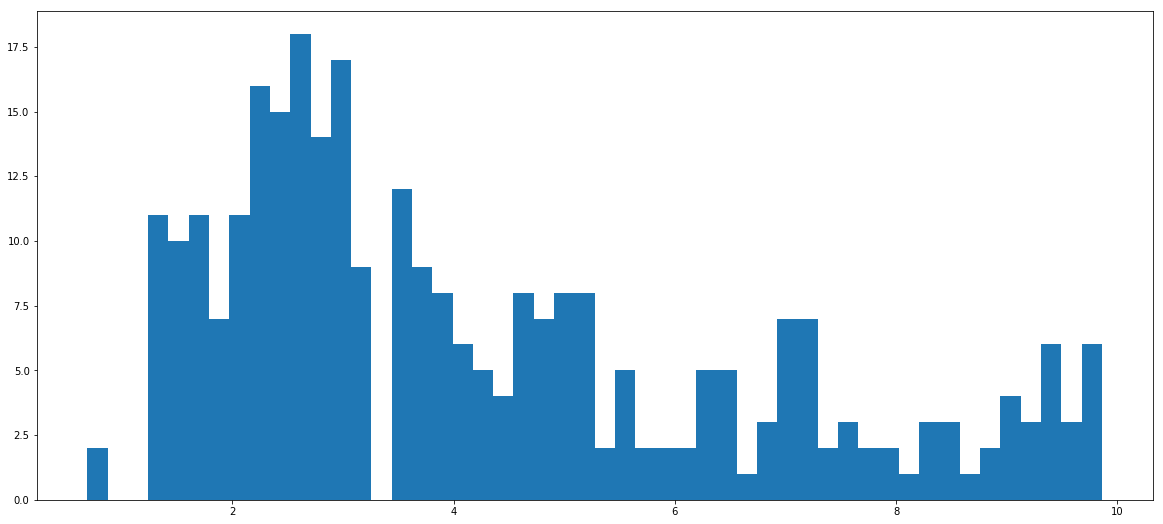

['Actor' 'AmbientPop' 'AmbientTechno' 'AnarchoPunk' 'Armenian' 'Ayo'
 'Ballad' 'BigRoom' 'Brooklyn' 'Cabaret' 'Cantautor' 'Cello' 'Choral'
 'Cinematic' 'DarkMetal' 'DeconstructedClub' 'Deep' 'DetroitTechno' 'Diva'
 'DominicanRepublic' 'DragQueen' 'DroneAmbient' 'Ecm' 'Electronicanica'
 'Eminem' 'Ethnic' 'FifthHarmony' 'FlyingNun' 'FrenchTheater' 'GFunk'
 'Game' 'Genius' 'Gothicboiclique' 'Impressionist' 'JazzSaxophone'
 'Jumpstyle' 'KkkCountry' 'Lithuanian' 'LittleStar' 'LixoAtomico' 'Love'
 'Mariachi' 'Mellow' 'Memphis' 'Merengue' 'MfDoom' 'Miami' 'MikePatton'
 'MinasGerais' 'Nct' 'NorthernSoul' 'OrthodoxBlackMetal' 'Outrun'
 'Pernambuco' 'PirateMetal' 'Poetry' 'PopRap' 'Psychill' 'Sadcore'
 'Schlager' 'Senegal' 'Showtunes' 'Soundcloud' 'SpokenWord' 'Stax'
 'StraightEdge' 'StreetPunk' 'SunshinePop' 'SymphonicProg' 'Taiwanese'
 'TechnicalDeathcore' 'Techstep' 'Teo' 'Treble' 'TwoTone' 'Ukulele'
 'Violin' 'Washington' 'Welsh' 'Wisconsin' 'Youngstar']


In [101]:
tf = TfidfVectorizer(lowercase = False)
ab = tf.fit_transform(artists['Tags'].values.astype('U'))
test = pd.DataFrame(index = artists['Artist'] , columns = tf.get_feature_names() , data = ab.toarray())
test.loc['Sums'] = test.sum(axis = 0)
test = test.transpose()
#10 is too big a thresold
weak = test[test['Sums'] < 10]
plt.figure(figsize = (20,9))
plt.hist(weak['Sums'] , bins = 50)
plt.show()
#According to the histogram 2.5 is a good threshhold
weaker = weak[weak['Sums'] < 2.5].reset_index()
print(weaker['index'].unique() )

Will remove all these tags except AnarchoPunk and StreetPunk.

I didnt remove these two music genres because they are subclasses of Punk and PunkRock Music.

Friends who tested this recommandation system, like PunkRock music so I want to have extra tags to work on.

Will remove them in future work.

In [102]:
to_remove = weaker['index'][(weaker['index'] != 'AnarchoPunk') & (weaker['index'] != 'StreetPunk')]
for i in to_remove:
    artists['Tags'] = artists['Tags'].str.replace(i,'')
#Fixing some minor issues
artists['Tags'] = artists['Tags'].str.replace(',,',',')
artists['Tags'] = artists['Tags'].str.replace("''","")
artists['Tags'] = artists['Tags'].str.replace('&','')
artists['Tags'] = artists['Tags'].str.replace("60S'S","60S")
artists




D:\aa\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\aa\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\aa\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_

Artist                                  Tags
0              Kanye West                        Rnb,HipHop,Rap
1           Billie Eilish                 Pop,Indie,Electronica
2             Post Malone              Trap,CloudRap,HipHop,Rap
3           Ariana Grande               Pop,FemaleVocalists,Rnb
4                Coldplay               Rock,Uk,Pop,Alternative
...                   ...                                   ...
13995      Kronos Quartet   Classical,Instrumental,Contemporary
13996         Wim Mertens  Minimal,Classical,Piano,Contemporary
13997           The Seeds           Psychedelic,60S,Rock,Garage
13998  The Appleseed Cast               PostRock,Indie,Rock,Emo
13999        Brand Nubian                Underground,HipHop,Rap

[10000 rows x 2 columns]

In [103]:
asd = artists['Tags'].str.split(',').tolist()
#Checking the length
ii = np.unique(flat(asd)) 
print(len(ii))
ii

432


array(['', '40S', '50S', '60S', '70S', '80S', '8Bit', '90S', 'ACappella',
       'AbstractHipHop', 'AcidHouse', 'AcidJazz', 'Acoustic',
       'AdultContemporary', 'African', 'Afrobeat', 'AltCountry',
       'Alternative', 'Ambient', 'American', 'AmericanBeats',
       'AnarchoPunk', 'Anime', 'AntiFolk', 'Aor', 'Argentina', 'ArtPop',
       'ArtRock', 'Atlanta', 'Atmospheric', 'AtmosphericBlackMetal',
       'AussieHipHop', 'Australian', 'Austrian', 'AvantGarde', 'Axe',
       'Bachata', 'BaileFunk', 'Baroque', 'BaroquePop', 'Bass', 'Beats',
       'Bebop', 'BedroomPop', 'Belgium', 'BigBand', 'BigBeats',
       'BlackMetal', 'Bluegrass', 'Blues', 'Bomba', 'BossaNova',
       'Boybands', 'Brazilian', 'Breakbeat', 'Breakcore', 'Brega',
       'Broadway', 'Brostep', 'BrutalDeathMetal', 'BrutalDeathcore',
       'BubblegumBass', 'CPop', 'California', 'Calm', 'Canadian',
       'Celtic', 'ChamberPop', 'Chanson', 'ChaoticHardcore', 'Chernobyl',
       'Chicago', 'Chile', 'Chill', 'Chillhop',

##### From 2000+ initial tags, the current number is just 431.

In [104]:
artists

Artist                                  Tags
0              Kanye West                        Rnb,HipHop,Rap
1           Billie Eilish                 Pop,Indie,Electronica
2             Post Malone              Trap,CloudRap,HipHop,Rap
3           Ariana Grande               Pop,FemaleVocalists,Rnb
4                Coldplay               Rock,Uk,Pop,Alternative
...                   ...                                   ...
13995      Kronos Quartet   Classical,Instrumental,Contemporary
13996         Wim Mertens  Minimal,Classical,Piano,Contemporary
13997           The Seeds           Psychedelic,60S,Rock,Garage
13998  The Appleseed Cast               PostRock,Indie,Rock,Emo
13999        Brand Nubian                Underground,HipHop,Rap

[10000 rows x 2 columns]

That concludes the Cleaning of the Artists Dataset.

Out of 2000+ tags I have reduced the number to slightly bellow 450 tags!

A good number for my recommandation system.

Moreover, I added some extra superclasses to the Artists so I can get better simillarity scores between "close" Artists

### 3 Metrics Datasets

On the second Dataset, the initial steps were : 

* Cleaning the dataframe 
* Doing some exploratory analysis to find insights and ways to improve the DataFrame

In [105]:
metrics = metrics.rename(columns = {'genre':'Genre' , 'artist_name':'Artist' , 'track_name':'Song'})
del metrics['track_id']
metrics['Song'] = metrics['Song'].str.lower() #to merge
metrics['Artist'] = metrics['Artist'].str.upper() # to merge
metrics = metrics.drop_duplicates()


In [106]:
metrics

Genre                    Artist                              Song  \
0       Movie            HENRI SALVADOR       c'est beau de faire un show   
1       Movie         MARTIN & LES FÉES  perdu d'avance (par gad elmaleh)   
2       Movie           JOSEPH WILLIAMS    don't let me be lonely tonight   
3       Movie            HENRI SALVADOR    dis-moi monsieur gordon cooper   
4       Movie              FABIEN NATAF                         ouverture   
...       ...                       ...                               ...   
232720   Soul                     SLAVE                      son of slide   
232721   Soul  JR THOMAS & THE VOLCANOS                      burning fire   
232722   Soul              MUDDY WATERS    (i'm your) hoochie coochie man   
232723   Soul                   R.LUM.R                     with my words   
232724   Soul            MINT CONDITION    you don't have to hurt no more   

        popularity  acousticness  danceability  duration_ms  energy  \
0                0       0.61100         0.389        99373   0.910   
1                1       0.24600         0.590       137373   0.737   
2                3       0.95200         0.663       170267   0.131   
3                0       0.70300         0.240       152427   0.326   
4                4       0.95000         0.331        82625   0.225   
...            ...           ...           ...          ...     ...   
232720          39       0.00384         0.687       326240   0.714   
232721          38       0.03290         0.785       282447   0.683   
232722          47       0.90100         0.517       166960   0.419   
232723          44       0.26200         0.745       222442   0.704   
232724          35       0.09730         0.758       323027   0.470   

        instrumentalness key  liveness  loudness   mode  speechiness    tempo  \
0               0.000000  C#    0.3460    -1.828  Major       0.0525  166.969   
1               0.000000  F#    0.1510    -5.559  Minor       0.0868  174.003   
2               0.000000   C    0.1030   -13.879  Minor       0.0362   99.488   
3               0.000000  C#    0.0985   -12.178  Major       0.0395  171.758   
4               0.123000   F    0.2020   -21.150  Major       0.0456  140.576   
...                  ...  ..       ...       ...    ...          ...      ...   
232720          0.544000   D    0.0845   -10.626  Major       0.0316  115.542   
232721          0.000880   E    0.2370    -6.944  Minor       0.0337  113.830   
232722          0.000000   D    0.0945    -8.282  Major       0.1480   84.135   
232723          0.000000   A    0.3330    -7.137  Major       0.1460  100.031   
232724          0.000049  G#    0.0836    -6.708  Minor       0.0287  113.897   

       time_signature  valence  
0                 4/4    0.814  
1                 4/4    0.816  
2                 5/4    0.368  
3                 4/4    0.227  
4                 4/4    0.390  
...               ...      ...  
232720            4/4    0.962  
232721            4/4    0.969  
232722            4/4    0.813  
232723            4/4    0.489  
232724            4/4    0.479  

[232720 rows x 17 columns]

### 3.1 Exploring the Dataset

After some basic cleaning the next steps were:

* Understanding every attribute
* Calculating correlation score between every attribute to check which metadata are highly correlated
* Changing letters into numbers in order to use them on the recommendation engine
* Visualizing some high correlated attributes to take more advantage of them
 


An explanation for each attribute:

**Reference:** https://pudding.cool/2018/05/similarity/ 

**Acousticness:**

* A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 
* 1.0 represents high confidence the track is acoustic.


**Danceability:**
* How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
* A value of 0.0 is least danceable and 1.0 is most danceable.

**Energy:**
* A perceptual measure of intensity and activity. 
* Typically, energetic tracks feel fast, loud, and noisy. 
* For example, death metal has high energy, while a Bach prelude scores low on the scale.
* Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**Instrumentalness:**
* Predicts whether a track contains no vocals. 
* “Ooh” and “aah” sounds are treated as instrumental in this context.
* Rap or spoken word tracks, are clearly “vocal”. 
* The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. 
* Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**Liveness:**
* Detects the presence of an audience in the recording.
* Higher liveness values represent an increased probability that the track was performed live.
* A value above 0.8 provides strong likelihood that the track is live.

**Loudness:**
* Overall loudness of a track in decibels (dB). 
* Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. 
* Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude).
* Values typical range between -60 and 0 db.

**Speechiness:**
* The presence of spoken words in a track. 
* The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. 
* Values above 0.66 describe tracks that are probably made entirely of spoken words.
* Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. 
* Values below 0.33 most likely represent music and other non-speech-like tracks.

**Valence:**
* The musical positiveness conveyed by a track. 
* Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric) 
* Tracks with low valence sound more negative (e.g. sad, depressed, angry).


In [107]:
#metrics
print(metrics.describe() )
#First of all i will convert keys and mode into numerical values.
print(metrics['key'].sort_values().unique() , "and the total length is :" , len(metrics['key'].unique()) )
print(metrics['mode'].unique() , "and the total length is :" , len(metrics['mode'].unique()) )
print(metrics['time_signature'].unique , "and the total length is :" , len(metrics['time_signature'].unique()) )

          popularity   acousticness   danceability   duration_ms  \
count  232720.000000  232720.000000  232720.000000  2.327200e+05   
mean       41.128150       0.368560       0.554364  2.351236e+05   
std        18.189483       0.354771       0.185610  1.189367e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037500       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657730e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  232720.000000     232720.000000  232720.000000  232720.000000   
mean        0.570957          0.148304       0.215009      -9.569922   
std         0.263458          0.302771       0.198272       5.998253   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.385000       

### 3.2 Converting letters into numbers

* Keys are letters from A to G#, so i will assign numbers 1 to 12.  A being 1 ,A# being 2 etc...
* Minor will be -1 and Major will be 1
* Similar approach for time signature

In [108]:
ai = metrics['key'].sort_values().unique()
bi = metrics['time_signature'].sort_values().unique()

for i in range(len(bi)):
    metrics['time_signature'] = metrics['time_signature'].replace(bi[i] , i)
metrics['time_signature']
for i in range(len(ai)):
    metrics['key'] = metrics['key'].replace(ai[i] , i)


metrics['mode'] = metrics['mode'].str.replace('Major' , '1')
metrics['mode'] = metrics['mode'].str.replace('Minor' , '-1')
metrics['mode'] = metrics['mode'].astype(int)
metrics

Genre                    Artist                              Song  \
0       Movie            HENRI SALVADOR       c'est beau de faire un show   
1       Movie         MARTIN & LES FÉES  perdu d'avance (par gad elmaleh)   
2       Movie           JOSEPH WILLIAMS    don't let me be lonely tonight   
3       Movie            HENRI SALVADOR    dis-moi monsieur gordon cooper   
4       Movie              FABIEN NATAF                         ouverture   
...       ...                       ...                               ...   
232720   Soul                     SLAVE                      son of slide   
232721   Soul  JR THOMAS & THE VOLCANOS                      burning fire   
232722   Soul              MUDDY WATERS    (i'm your) hoochie coochie man   
232723   Soul                   R.LUM.R                     with my words   
232724   Soul            MINT CONDITION    you don't have to hurt no more   

        popularity  acousticness  danceability  duration_ms  energy  \
0                0       0.61100         0.389        99373   0.910   
1                1       0.24600         0.590       137373   0.737   
2                3       0.95200         0.663       170267   0.131   
3                0       0.70300         0.240       152427   0.326   
4                4       0.95000         0.331        82625   0.225   
...            ...           ...           ...          ...     ...   
232720          39       0.00384         0.687       326240   0.714   
232721          38       0.03290         0.785       282447   0.683   
232722          47       0.90100         0.517       166960   0.419   
232723          44       0.26200         0.745       222442   0.704   
232724          35       0.09730         0.758       323027   0.470   

        instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0               0.000000    4    0.3460    -1.828     1       0.0525  166.969   
1               0.000000    9    0.1510    -5.559    -1       0.0868  174.003   
2               0.000000    3    0.1030   -13.879    -1       0.0362   99.488   
3               0.000000    4    0.0985   -12.178     1       0.0395  171.758   
4               0.123000    8    0.2020   -21.150     1       0.0456  140.576   
...                  ...  ...       ...       ...   ...          ...      ...   
232720          0.544000    5    0.0845   -10.626     1       0.0316  115.542   
232721          0.000880    7    0.2370    -6.944    -1       0.0337  113.830   
232722          0.000000    5    0.0945    -8.282     1       0.1480   84.135   
232723          0.000000    0    0.3330    -7.137     1       0.1460  100.031   
232724          0.000049   11    0.0836    -6.708    -1       0.0287  113.897   

        time_signature  valence  
0                    3    0.814  
1                    3    0.816  
2                    4    0.368  
3                    3    0.227  
4                    3    0.390  
...                ...      ...  
232720               3    0.962  
232721               3    0.969  
232722               3    0.813  
232723               3    0.489  
232724               3    0.479  

[232720 rows x 17 columns]

### 3.3 Calculating Correlation Scores between attributes

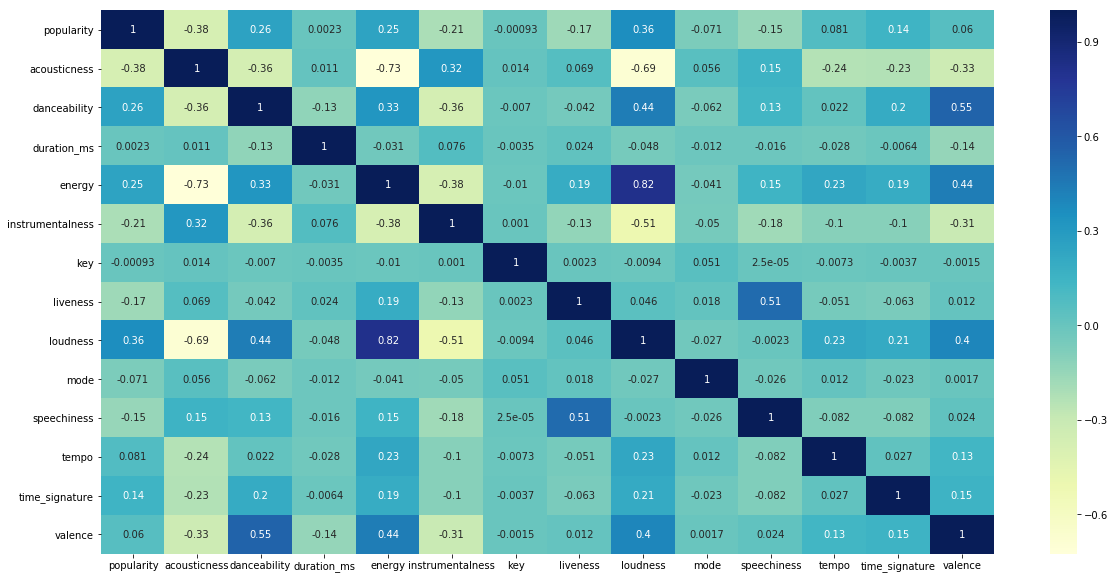

<function seaborn.rcmod.reset_orig()>

In [109]:
#Correlation heatmap
import seaborn as sns
corr = metrics[['popularity', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
       'valence']]
plt.figure(figsize = (20,10))
sns.heatmap(corr.corr() , annot = True , cmap = "YlGnBu")

plt.show()
sns.reset_orig

**High Correlation between** 
 * loudness and energy
 * Valence and danceability
 * energy and valancee
 * speachness and liveness->obvious

**Negative correlation:**

Some are very obvious

* energy-instrumentalness??
* instrumentalness-valance
* energy accousticness ->obvious
* loudness-accousticness



Valence is one of the most imporant attributes since it demonstrates the "mood" of the song

Key has very small correlation with all the other values. I wont include it in the final dataset.

Will also normalize the data

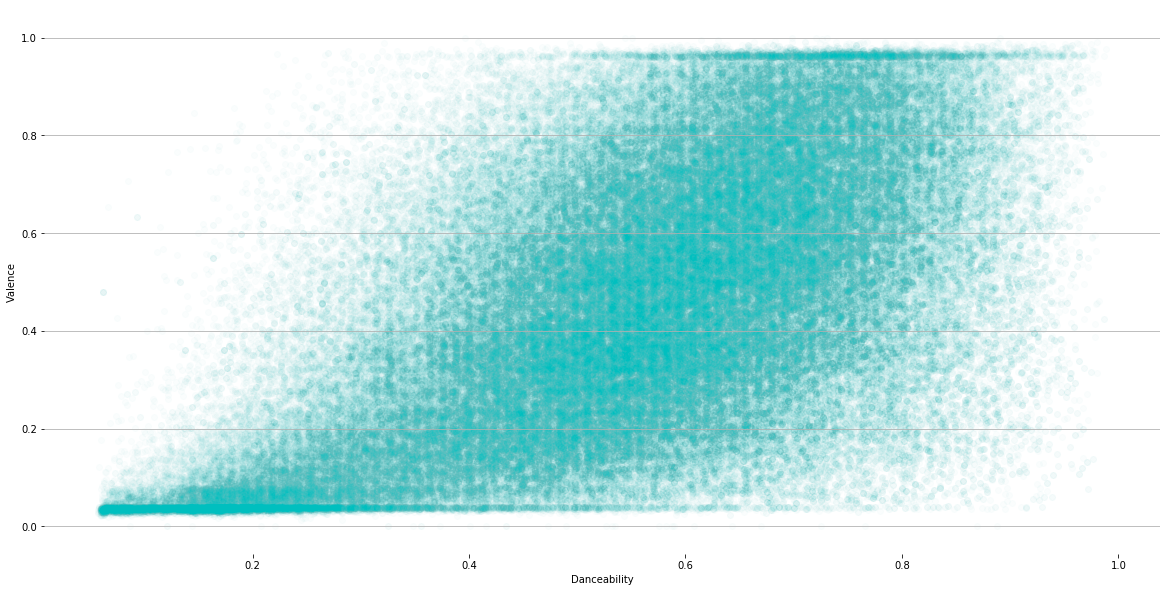

In [110]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

plt.scatter(metrics['danceability'] , metrics['valence'] , color = 'c',alpha = 0.02)

plt.grid(b = True , axis = 'y')
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.xlabel('Danceability')
plt.ylabel('Valence')
plt.show()

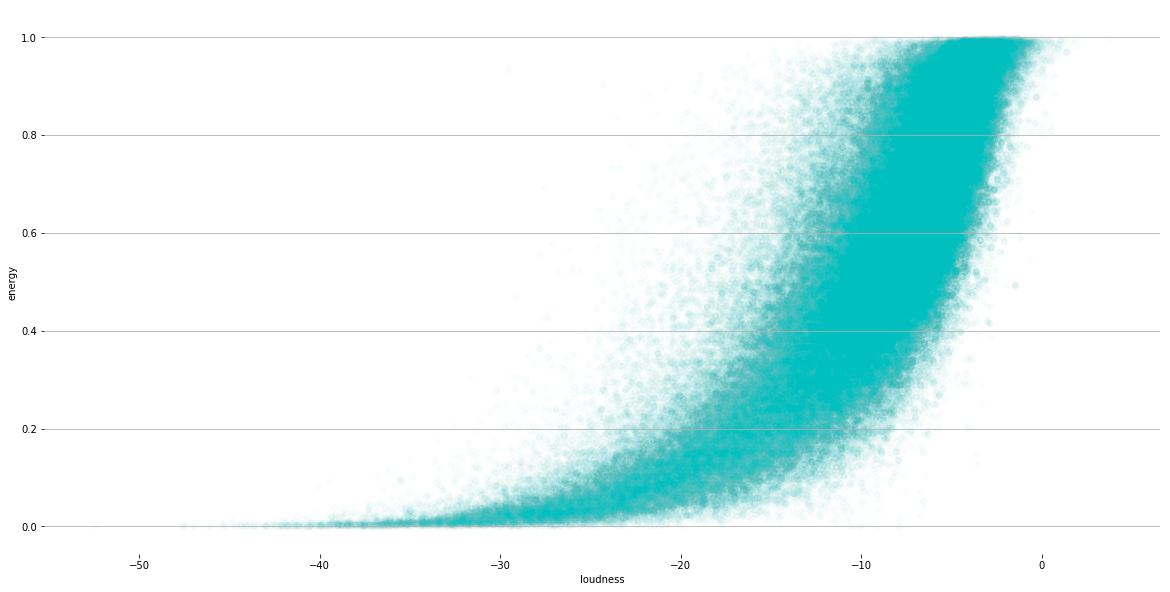

In [111]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)

plt.scatter(metrics['loudness'], metrics['energy'] , color = 'c',alpha = 0.02)

plt.grid(b = True , axis = 'y')
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.xlabel('loudness')
plt.ylabel('energy')
plt.show()

The most interesting part here is that most songs that are low on valance are those which have low danceability

While for danceability >0.4 valance is over 0.4 as well

Three different trends:
 * Low valance songs=>low danceability
 * High valance songs=>high danceability
 * As danceability rises,so does valence

D:\aa\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


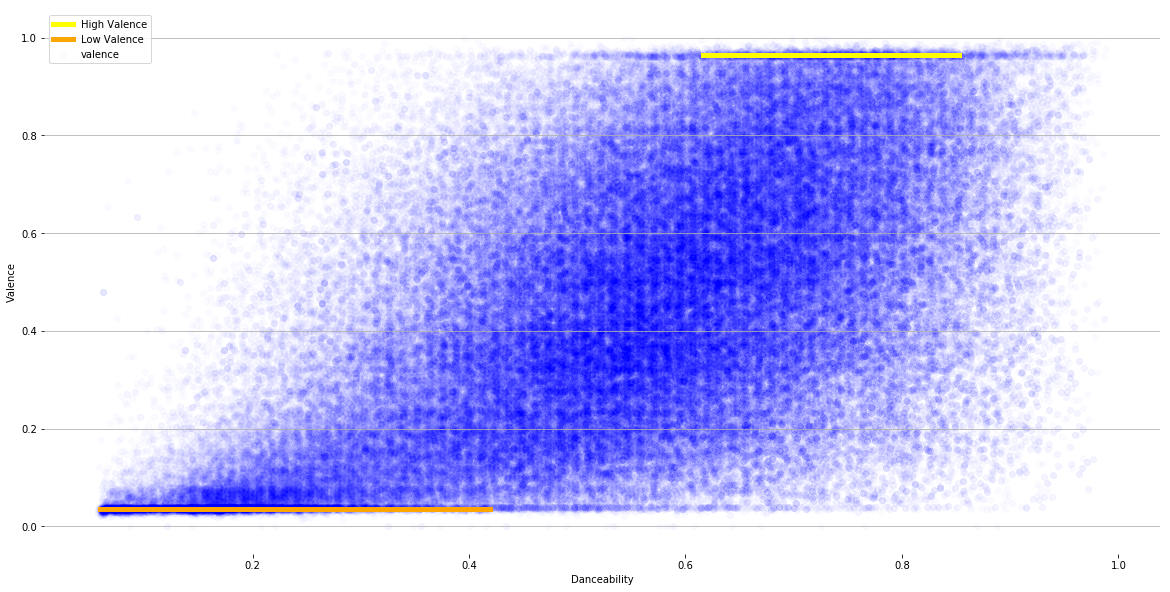

In [112]:

plt.figure(figsize = (20,10))
ax=fig.add_subplot(111)

plt.scatter(metrics['danceability'] , metrics['valence'] , color = 'blue' , alpha = 0.02)
plt.axhline(y = 0.965 , linestyle = '-' , xmin = 0.59 , xmax = 0.82 , color = 'yellow' , linewidth = 5 , label = 'High Valence')
plt.axhline(y = 0.035 , linestyle = '-' , xmin = 0.05 , xmax = 0.4 , color = 'orange' , linewidth = 5 , label = 'Low Valence')
plotdf = metrics[(metrics['valence'] > 0.035) & (metrics['valence'] < 0.965)]




plt.grid(b = True , axis = 'y')
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.legend()
plt.xlabel('Danceability')
plt.ylabel('Valence')
plt.show()

Songs that are meant for dancing are happier in general

D:\aa\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


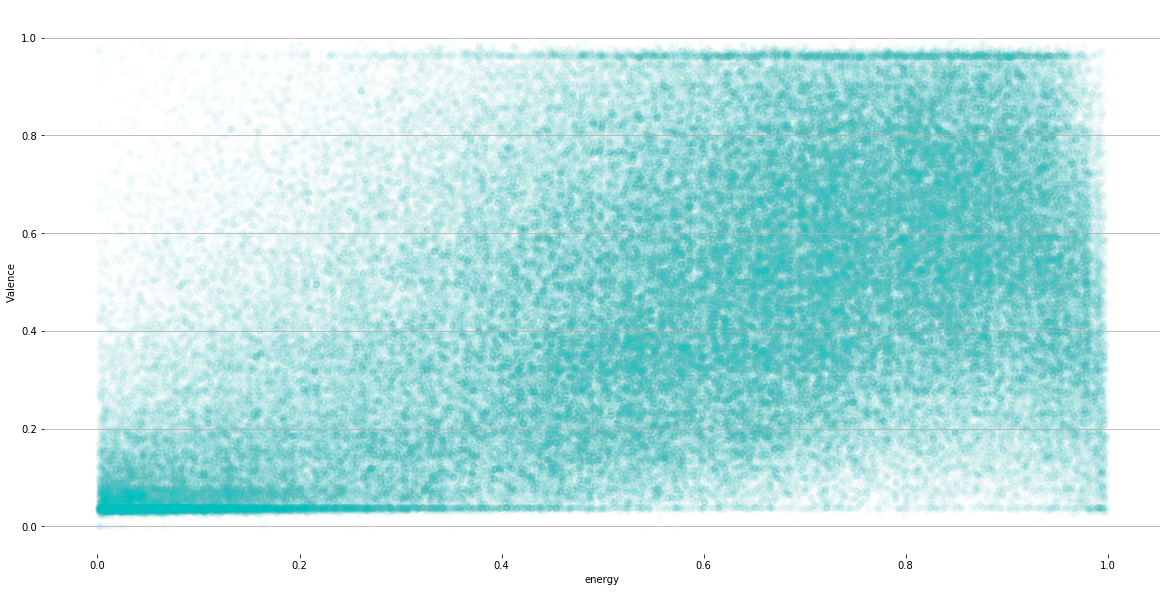

In [113]:
#Similarly for energy:
plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)

plt.scatter(metrics['energy'] , metrics['valence'] , color = 'c' , alpha = 0.02)

plt.grid(b = True , axis = 'y')
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.xlabel('energy')
plt.ylabel('Valence')
plt.show()

Patterns here are very difficult to be identified.
* Some interesting ones are that the lowest on energy songs have very low valence 
* Most valence is on the songs with  energy>0.6

D:\aa\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


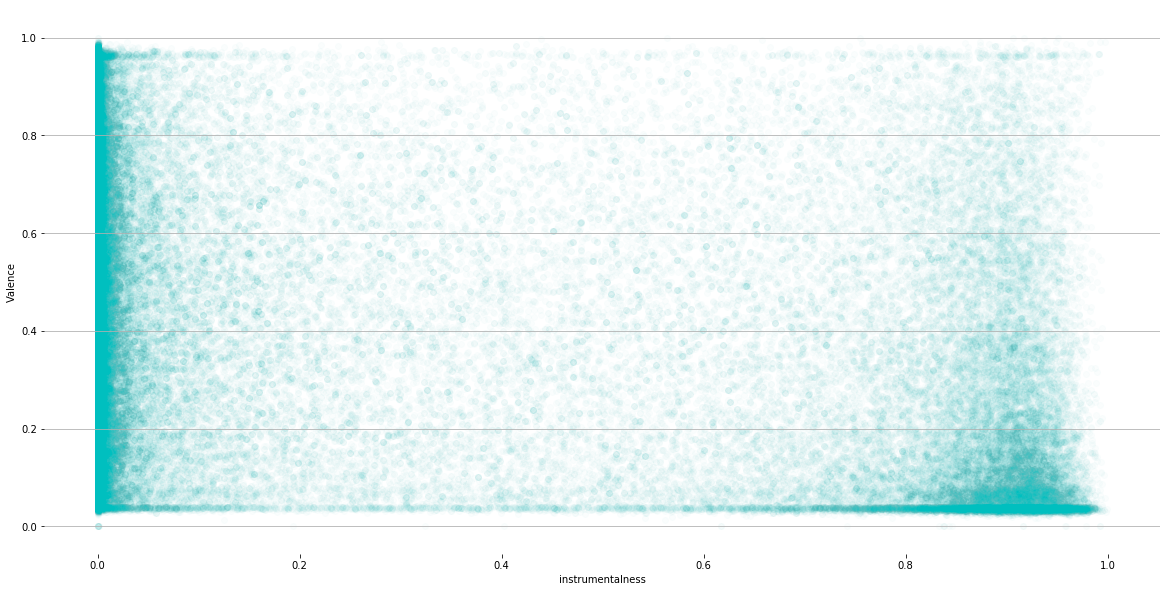

In [114]:
#Similarly for instrumenltaness:
plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)

plt.scatter(metrics['instrumentalness'] , metrics['valence'] , color = 'c' , alpha = 0.02)

plt.grid(b = True , axis = 'y')
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.xlabel('instrumentalness')
plt.ylabel('Valence')
plt.show()

* Songs with not so many vocals are low on valance 
* Songs with a lot of vocals can differ in valance.

D:\aa\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


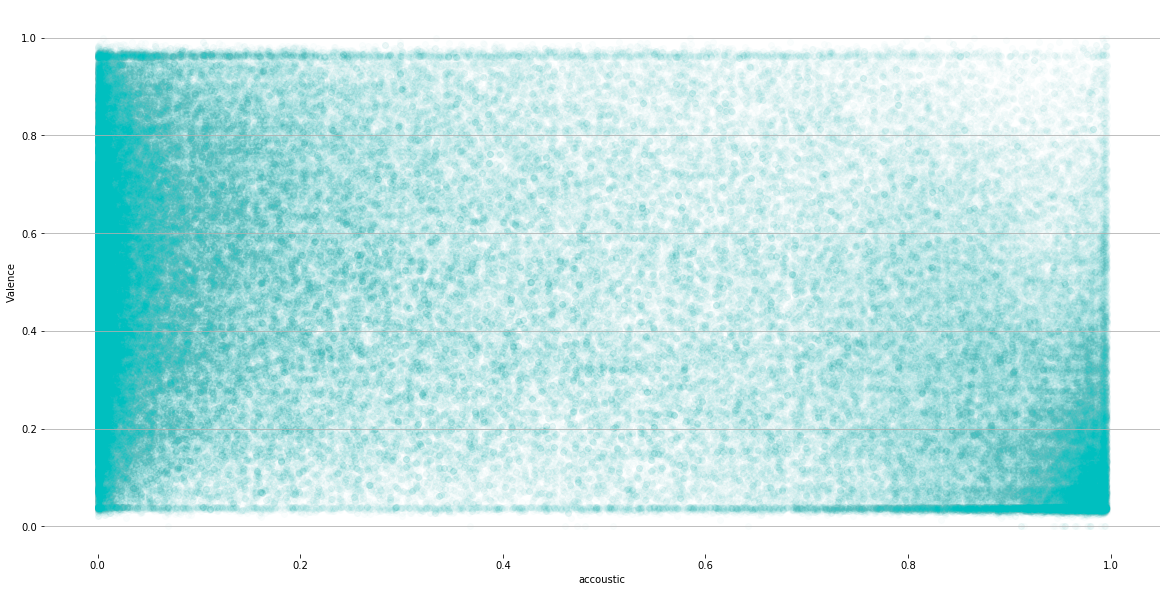

In [115]:
plt.figure(figsize=(20,10))
ax =  fig.add_subplot(111)

plt.scatter(metrics['acousticness'] , metrics['valence'] , color = 'c' , alpha = 0.02)

plt.grid(b = True , axis = 'y')
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.xlabel('accoustic')
plt.ylabel('Valence')
plt.show()

Accoustic songs are sad songs in general

In [116]:
print(metrics.columns)
metrics

Index(['Genre', 'Artist', 'Song', 'popularity', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
       'valence'],
      dtype='object')


Genre                    Artist                              Song  \
0       Movie            HENRI SALVADOR       c'est beau de faire un show   
1       Movie         MARTIN & LES FÉES  perdu d'avance (par gad elmaleh)   
2       Movie           JOSEPH WILLIAMS    don't let me be lonely tonight   
3       Movie            HENRI SALVADOR    dis-moi monsieur gordon cooper   
4       Movie              FABIEN NATAF                         ouverture   
...       ...                       ...                               ...   
232720   Soul                     SLAVE                      son of slide   
232721   Soul  JR THOMAS & THE VOLCANOS                      burning fire   
232722   Soul              MUDDY WATERS    (i'm your) hoochie coochie man   
232723   Soul                   R.LUM.R                     with my words   
232724   Soul            MINT CONDITION    you don't have to hurt no more   

        popularity  acousticness  danceability  duration_ms  energy  \
0                0       0.61100         0.389        99373   0.910   
1                1       0.24600         0.590       137373   0.737   
2                3       0.95200         0.663       170267   0.131   
3                0       0.70300         0.240       152427   0.326   
4                4       0.95000         0.331        82625   0.225   
...            ...           ...           ...          ...     ...   
232720          39       0.00384         0.687       326240   0.714   
232721          38       0.03290         0.785       282447   0.683   
232722          47       0.90100         0.517       166960   0.419   
232723          44       0.26200         0.745       222442   0.704   
232724          35       0.09730         0.758       323027   0.470   

        instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0               0.000000    4    0.3460    -1.828     1       0.0525  166.969   
1               0.000000    9    0.1510    -5.559    -1       0.0868  174.003   
2               0.000000    3    0.1030   -13.879    -1       0.0362   99.488   
3               0.000000    4    0.0985   -12.178     1       0.0395  171.758   
4               0.123000    8    0.2020   -21.150     1       0.0456  140.576   
...                  ...  ...       ...       ...   ...          ...      ...   
232720          0.544000    5    0.0845   -10.626     1       0.0316  115.542   
232721          0.000880    7    0.2370    -6.944    -1       0.0337  113.830   
232722          0.000000    5    0.0945    -8.282     1       0.1480   84.135   
232723          0.000000    0    0.3330    -7.137     1       0.1460  100.031   
232724          0.000049   11    0.0836    -6.708    -1       0.0287  113.897   

        time_signature  valence  
0                    3    0.814  
1                    3    0.816  
2                    4    0.368  
3                    3    0.227  
4                    3    0.390  
...                ...      ...  
232720               3    0.962  
232721               3    0.969  
232722               3    0.813  
232723               3    0.489  
232724               3    0.479  

[232720 rows x 17 columns]

**At first high correlated values were merged into a single features due to their simmilarity**. 

However, Because they regard a different song feature and after considering the results with and without merging them, I kept them splitted.

Moreover , after considering several regression techniques to find calculate on attribute by exploring the other, MSE was very high

**As a result, the attributes were kept splitted**

On the other hand

* Key and major wont be important for my recommandations
* Neither does time_stamp and duration
* Popularity will be included but wont be used in the first place
* Moreover i wont consider genres here, since I have a separate dataset for it

**The above attributes were removed**

Will also normalize the data so everything has the same scale:


In [117]:
metrics['tempo'] = metrics['tempo']/1000
metrics['loudness'] = metrics['loudness']/10

metrics = metrics[['Artist','Song','Genre','popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness',
                'liveness','loudness',  'speechiness', 'tempo','valence']]
#Test between metrics and artists
print("metrics have " , len(metrics) , " songs")
metrics = metrics.sort_values('Artist')
print('artists have ' , len(artists) ,' artists')
#Some basic analysis on my bands set of metrics,in case i find some insights
bands = metrics.groupby('Artist').count()
print("There is a total of " , len(bands) ," artists")
print("Every band has a mean of " , bands['Song'].mean() , " songs")
#print("their merge have ",len(pd.merge(metrics,artists,how='inner',on='Artist').drop_duplicates()), "songs")
#Seems ok,maybe later will try raising the number
metrics


metrics have  232720  songs
artists have  10000  artists
There is a total of  14561  artists
Every band has a mean of  15.982418789918276  songs


Artist                                         Song  \
36510              !!!                        get that rhythm right   
36675              !!!                                 except death   
99191              !!!                   even when the water's cold   
23712              !!!                               lucy mongoosey   
36523              !!!                            funk (i got this)   
...                ...                                          ...   
218602  어노인팅 ANOINTING                                  you are god   
221745  어노인팅 ANOINTING                                 소원 one thing   
218661  어노인팅 ANOINTING                  나는 예배자 입니다 i am a worshiper   
220986  어노인팅 ANOINTING  하나님의 그늘 아래 under the shadow of the almighty   
84072              정진우                   i'll find you (feat. june)   

                   Genre  popularity  acousticness  danceability  energy  \
36510         Electronic          39       0.03820         0.832   0.798   
36675         Electronic          37       0.00996         0.812   0.776   
99191   Children’s Music          61       0.10800         0.709   0.831   
23712         Electronic          48       0.01940         0.872   0.584   
36523         Electronic          35       0.01620         0.932   0.546   
...                  ...         ...           ...           ...     ...   
218602             World          27       0.69200         0.505   0.629   
221745             World          22       0.63700         0.386   0.894   
218661             World          27       0.85400         0.511   0.445   
220986             World          23       0.75600         0.282   0.345   
84072                R&B          45       0.38700         0.369   0.453   

        instrumentalness  liveness  loudness  speechiness     tempo  valence  
36510           0.104000    0.0980   -0.7418       0.0475  0.120022    0.961  
36675           0.070600    0.0737   -0.7223       0.0386  0.118021    0.912  
99191           0.001280    0.1590   -0.6847       0.0391  0.104971    0.866  
23712           0.000850    0.1130   -0.7412       0.0788  0.109987    0.212  
36523           0.494000    0.0891   -0.8462       0.1750  0.116016    0.440  
...                  ...       ...       ...          ...       ...      ...  
218602          0.000000    0.6870   -0.8847       0.0369  0.109994    0.244  
221745          0.000003    0.3550   -0.5414       0.0544  0.125752    0.329  
218661          0.000000    0.5890   -0.8401       0.0280  0.124417    0.201  
220986          0.000000    0.0868   -0.9464       0.0301  0.123098    0.129  
84072           0.000000    0.1210   -0.8442       0.1480  0.084079    0.235  

[232720 rows x 13 columns]

In [118]:
metrics.head()

Artist                        Song             Genre  popularity  \
36510    !!!       get that rhythm right        Electronic          39   
36675    !!!                except death        Electronic          37   
99191    !!!  even when the water's cold  Children’s Music          61   
23712    !!!              lucy mongoosey        Electronic          48   
36523    !!!           funk (i got this)        Electronic          35   

       acousticness  danceability  energy  instrumentalness  liveness  \
36510       0.03820         0.832   0.798           0.10400    0.0980   
36675       0.00996         0.812   0.776           0.07060    0.0737   
99191       0.10800         0.709   0.831           0.00128    0.1590   
23712       0.01940         0.872   0.584           0.00085    0.1130   
36523       0.01620         0.932   0.546           0.49400    0.0891   

       loudness  speechiness     tempo  valence  
36510   -0.7418       0.0475  0.120022    0.961  
36675   -0.7223       0.0386  0.118021    0.912  
99191   -0.6847       0.0391  0.104971    0.866  
23712   -0.7412       0.0788  0.109987    0.212  
36523   -0.8462       0.1750  0.116016    0.440

In [119]:
metrics_genre=metrics.groupby('Genre').agg({'acousticness':(np.mean,np.std),'danceability':(np.mean,np.std),'energy':(np.mean,np.std),
                                           'instrumentalness':(np.mean,np.std),'liveness':(np.mean,np.std),'loudness':(np.mean,np.std),
                                           'speechiness':(np.mean,np.std),'valence':(np.mean,np.std)}).reset_index()





metrics_genre

Genre acousticness           danceability              energy  \
                             mean       std         mean       std      mean   
0          A Capella     0.829941  0.181866     0.412252  0.179719  0.250313   
1        Alternative     0.162313  0.241155     0.541898  0.150391  0.711519   
2              Anime     0.286843  0.362341     0.472090  0.149229  0.665356   
3              Blues     0.327840  0.309981     0.528232  0.145147  0.606171   
4   Children's Music     0.591925  0.313774     0.697517  0.156004  0.396795   
5   Children’s Music     0.163129  0.239813     0.541856  0.147105  0.706621   
6          Classical     0.868843  0.255269     0.305958  0.135201  0.177984   
7             Comedy     0.793152  0.130208     0.559033  0.089628  0.676082   
8            Country     0.270172  0.262801     0.577038  0.109771  0.636318   
9              Dance     0.152888  0.184252     0.638191  0.126575  0.698067   
10        Electronic     0.119839  0.200477     0.619542  0.146418  0.739299   
11              Folk     0.463201  0.334784     0.527276  0.132496  0.491733   
12           Hip-Hop     0.176172  0.188891     0.718808  0.130642  0.643275   
13             Indie     0.331214  0.321618     0.566821  0.140346  0.581002   
14              Jazz     0.499606  0.337637     0.585638  0.158903  0.472776   
15             Movie     0.697341  0.277379     0.491186  0.178861  0.370703   
16             Opera     0.945202  0.057516     0.290650  0.112660  0.168779   
17               Pop     0.224819  0.250306     0.640236  0.141266  0.642208   
18               R&B     0.288216  0.262520     0.642125  0.137701  0.564248   
19               Rap     0.168080  0.189780     0.697244  0.141120  0.650520   
20            Reggae     0.185783  0.204736     0.699271  0.121033  0.635749   
21         Reggaeton     0.218923  0.180025     0.731260  0.096116  0.748836   
22              Rock     0.196429  0.252861     0.538292  0.133388  0.683670   
23               Ska     0.099728  0.174256     0.526799  0.164059  0.815585   
24              Soul     0.360679  0.288262     0.617645  0.137804  0.532506   
25        Soundtrack     0.717349  0.292065     0.265616  0.150734  0.221110   
26             World     0.393341  0.363125     0.443293  0.166094  0.506453   

             instrumentalness            liveness            loudness  \
         std             mean       std      mean       std      mean   
0   0.198740         0.007491  0.040491  0.136924  0.063144 -1.366039   
1   0.206063         0.061303  0.176176  0.196985  0.157880 -0.654080   
2   0.299668         0.280592  0.391047  0.192391  0.139406 -0.791780   
3   0.229498         0.095175  0.213789  0.233125  0.219053 -0.905381   
4   0.205863         0.143622  0.304050  0.164932  0.137384 -1.164315   
5   0.205322         0.054346  0.166418  0.194996  0.152904 -0.652660   
6   0.225483         0.599425  0.377911  0.162810  0.145103 -2.154448   
7   0.211712         0.000574  0.009988  0.724790  0.223443 -1.169005   
8   0.200344         0.005610  0.041811  0.187216  0.153139 -0.734169   
9   0.160860         0.035449  0.143123  0.187753  0.148386 -0.605424   
10  0.188646         0.350955  0.361364  0.210006  0.177842 -0.703587   
11  0.230968         0.084934  0.209306  0.170773  0.144907 -0.987028   
12  0.150037         0.011200  0.073822  0.201146  0.156169 -0.686029   
13  0.217834         0.085317  0.209438  0.168919  0.126682 -0.791514   
14  0.237807         0.358009  0.383488  0.173355  0.151554 -1.121046   
15  0.237548         0.125427  0.281954  0.228715  0.197256 -1.295209   
16  0.117803         0.232013  0.347569  0.223264  0.193768 -1.933977   
17  0.182855         0.016599  0.094935  0.179967  0.135340 -0.649542   
18  0.167602         0.025558  0.115646  0.175350  0.135170 -0.759706   
19  0.156686         0.009317  0.065828  0.198939  0.152349 -0.666992   
20  0.161206         0.039972  0.150182  0.193076  0.181150 -0.751811   
21  0.125012   

**In another project I could focus on the exploratory part and find more interesting insights that come with music genres.**



### 4. Preparing the Datasets For Merging

An initial check on the Artists names on the first two DataSets

No handles with labels found to put in legend.


There is a total of  14561  artists
Every band has a mean of  15.982418789918276  songs


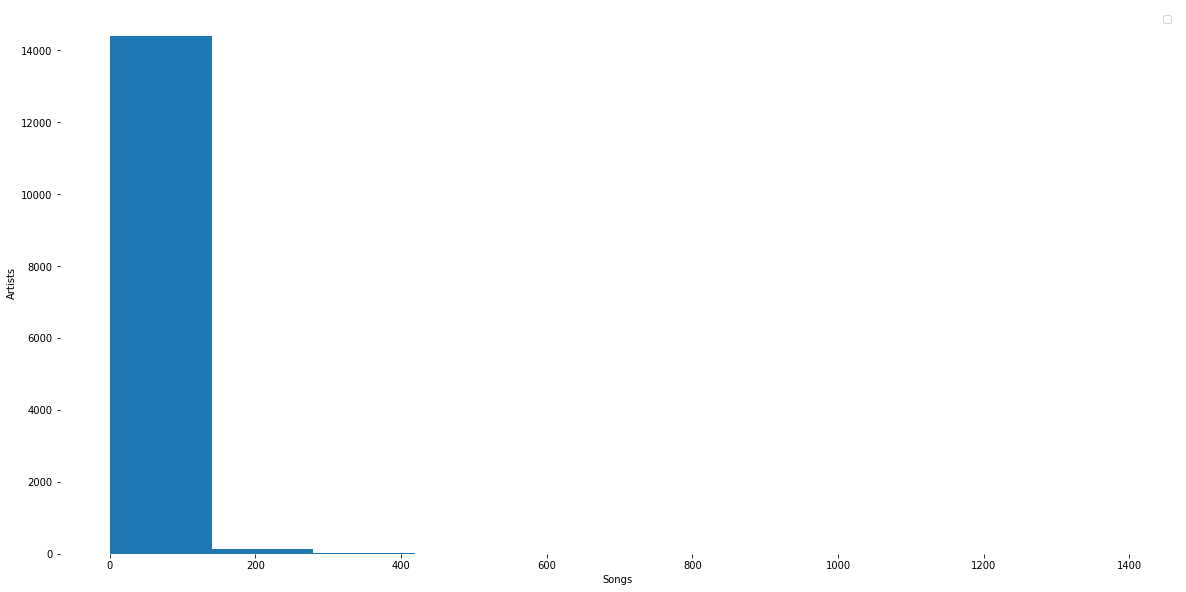

In [120]:
bands = metrics.groupby('Artist').count()
print("There is a total of " , len(bands) , " artists")
print("Every band has a mean of " , bands['Song'].mean() , " songs")


#Plotting the hystogram
plt.figure(figsize = (20,10))
plt.hist(bands['Song'])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.legend()
plt.xlabel('Songs')
plt.ylabel('Artists')
plt.show()

Checking the number of the total number of Artists which have the same name on the two initial Datasets so I can merge them

In [121]:
artists['Artist'] = artists['Artist'].str.upper()
len(pd.merge(artists , metrics , on = 'Artist' , how = 'inner'))

D:\aa\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


150830

**There is a huge difference in the number of artists between the two datasets.**

Since in the metrics dataset the mean value of songs of every Artist is 15 => I am missing plenty of artists.

### 4.1 Collaborative Filtering Datasets

A first limitation on creating the recommendation system engine is that on the final dataset:

* Each Artists have different songs on the third datasets than on the other two
* Many Artists and songs names are spelled differently


In [122]:
colabor = colabor.rename(columns = {'song':'song_id'})
colabor = pd.merge(songs , colabor , on = 'song_id',how = 'inner').drop_duplicates()
colabor = colabor[['title' , 'artist_name' , 'user' , 'play_count','song_id']]
colabor = colabor.rename(columns={'title':'Song' , 'artist_name':'Artist'})
colabor

Song                     Artist  \
0        Anyone Else But You  Michael Cera & Ellen Page   
1        Anyone Else But You  Michael Cera & Ellen Page   
2        Anyone Else But You  Michael Cera & Ellen Page   
3        Anyone Else But You  Michael Cera & Ellen Page   
4        Anyone Else But You  Michael Cera & Ellen Page   
...                      ...                        ...   
2086941      The Outer Banks             The Album Leaf   
2086942      The Outer Banks             The Album Leaf   
2086943      The Outer Banks             The Album Leaf   
2086944      The Outer Banks             The Album Leaf   
2086945      The Outer Banks             The Album Leaf   

                                             user  play_count  \
0        d6589314c0a9bcbca4fee0c93b14bc402363afea           6   
1        484b69dd013df1ec0cfd504886d4f647cb32b08f           1   
2        3f9ed694a79835c921ef6d94acd28f876c1d901e           4   
3        b882a5b0dbd1a80533e40745be976f19d1fad5b0           1   
4        2bcef2a30bd8913405971761a0e6c292d771c086           1   
...                                           ...         ...   
2086941  37781fff15682ccd92aface63f66d3f525e2f88f           1   
2086942  49e66adb87d5d39781add88c202aa9802010e848           3   
2086943  9d659bb73b93384297f240a4adadccf4d81bd681           1   
2086944  c65a346ab8f41fb56926b503ece810f358b0d241           1   
2086945  84e72d86fab784be544a8e2fe2826c73530165fd           1   

                    song_id  
0        SOSZNRJ12A8AE46E38  
1        SOSZNRJ12A8AE46E38  
2        SOSZNRJ12A8AE46E38  
3        SOSZNRJ12A8AE46E38  
4        SOSZNRJ12A8AE46E38  
...                     ...  
2086941  SOBPQCK12AF72A2FD5  
2086942  SOBPQCK12AF72A2FD5  
2086943  SOBPQCK12AF72A2FD5  
2086944  SOBPQCK12AF72A2FD5  
2086945  SOBPQCK12AF72A2FD5  

[2054534 rows x 5 columns]

### 4.2 Preparing the Datasets for merging:

 * Changing columns names
 * Changing the names of Artists so everything is with Capital letters
 * Removing special characters
 * Changing the Songs so every first letter is Capital

In [123]:
metrics['Song']=metrics['Song'].str.replace("(\(.*?\))","").str.strip().str.title()
songs=songs.rename(columns={'Song1':'Song'})
colabor['Artist']=colabor['Artist'].str.upper()
songs=songs.rename(columns={'artist_name':'Artist','title':'Song'})
songs['Artist']=songs['Artist'].str.upper()
songs['Song']=songs['Song'].str.replace("(\(.*?\))","").str.strip().str.title()
songs

song_id                                 Song  \
0       SOQMMHC12AB0180CB8                         Silent Night   
1       SOVFVAK12A8C1350D9                          Tanssi Vaan   
2       SOGTUKN12AB017F4F1                    No One Could Ever   
3       SOBNYVR12A8C13558C                        Si Vos Querés   
4       SOHSBXH12A8C13B0DF                     Tangle Of Aspens   
...                    ...                                  ...   
999995  SOTXAME12AB018F136                      O Samba Da Vida   
999996  SOXQYIQ12A8C137FBB                         Jago Chhadeo   
999997  SOHODZI12A8C137BB3                              Novemba   
999998  SOLXGOR12A81C21EB7                              Faraday   
999999  SOWXJXQ12AB0189F43  Fernweh Feat. Sektion Kuchikäschtli   

                                     release            Artist  year  
0                      Monster Ballads X-Mas  FASTER PUSSY CAT  2003  
1                                Karkuteillä  KARKKIAUTOMAATTI  1995  
2                                     Butter    HUDSON MOHAWKE  2006  
3                                    De Culo       YERBA BRAVA  2003  
4       Rene Ablaze Presents Winter Sessions        DER MYSTIC     0  
...                                      ...               ...   ...  
999995                          Pacha V.I.P.      KIKO NAVARRO     0  
999996              Naale Baba Lassi Pee Gya     KULDEEP MANAK     0  
999997       Dub_Connected: electronic music    GABRIEL LE MAR     0  
999998          The Trance Collection Vol. 2             ELUDE     0  
999999                            So Oder So             TEXTA  2004  

[1000000 rows x 5 columns]

Merging:

In [124]:
test=pd.merge(songs,metrics,on=['Artist','Song'],how='inner').drop_duplicates(['Song','Artist'])
test


song_id                   Song  \
0      SOHMYGC12A6D4FAC4B    Dancing In The Dark   
1      SONTDUZ12D021989FD                Rowboat   
2      SOGKDCA12A8C141C21  The Itsy Bitsy Spider   
3      SOBGXZN12AB0188FBD     Atrevida Bandolera   
4      SOKVLUT12A6D4F79FC  Please Set Me At Ease   
...                   ...                    ...   
50398  SODDNYE12A8C13A6AF       Fuera De Control   
50399  SOUEZMI12AB018786C       A Little Respect   
50401  SOHDQXP12A8C143532            Mover Music   
50402  SOBPPJS12A58A76086               Dividers   
50403  SOKYCUN12A6D4FDA63        You Too & Stuff   

                                    release              Artist  year  \
0                          The Look Of Love         DIANA KRALL  2001   
1                                 Unchained         JOHNNY CASH  1996   
2                         Dora The Explorer   DORA THE EXPLORER     0   
3                             12 Discipulos              VOLTIO     0   
4                          Blue Break Beats      BOBBI HUMPHREY  1975   
...                                     ...                 ...   ...   
50398               El Cartel: The Big Boss        DADDY YANKEE  2007   
50399                          Pop! Remixed             ERASURE     0   
50401  Imagination Movers: Juice Box Heroes  IMAGINATION MOVERS     0   
50402                                 Blaze            LAGWAGON  2003   
50403                      Brian Regan Live         BRIAN REGAN  1997   

                  Genre  popularity  acousticness  danceability  energy  \
0                  Jazz          43      0.419000         0.550   0.339   
1               Country          35      0.279000         0.585   0.487   
2      Children's Music           9      0.785000         0.766   0.226   
3             Reggaeton          24      0.280000         0.751   0.895   
4                  Jazz          40      0.921000         0.343   0.299   
...                 ...         ...           ...           ...     ...   
50398         Reggaeton          36      0.088500         0.848   0.631   
50399             Dance          63      0.008080         0.596   0.598   
50401  Children's Music          12      0.055100         0.672   0.933   
50402               Ska          23      0.000258         0.251   0.964   
50403            Comedy          43      0.794000         0.557   0.635   

       instrumentalness  liveness  loudness  speechiness     tempo  valence  
0              0.316000    0.1120   -1.5477       0.0272  0.109218    0.482  
1              0.015100    0.1750   -0.6871       0.0277  0.119167    0.325  
2              0.000000    0.1650   -0.5875       0.0550  0.093050    0.877  
3              0.000000    0.1910   -0.5959       0.0797  0.094024    0.726  
4              0.218000    0.0944   -1.7572       0.0584  0.070117    0.322  
...                 ...       ...       ...          ...       ...      ...  
50398          0.000013    0.0529   -0.6141       0.1540  0.090016    0.721  
50399          0.000003    0.2410   -1.3409       0.0268  0.113825    0.595  
50401          0.007850    0.2320   -0.3921       0.0716  0.150116    0.950  
50402          0.000035    0.0250   -0.4103       0.0683  0.098481    0.252  
50403          0.000003    0.9210   -1.4276       0.8870  0.131606    0.213  

[20747 rows x 16 columns]

Not big sample size , will try to raise the number!

**Many Artists have different spelling on the different datasets**


### 4.4  To increase the sample size :

 * Will calculate distances between Artists that are missing from the merged Dataset
 * Will find Artists that are the same but Misspeled.
 * Will change them in order to increase the sample size


In [125]:
song_metrics = pd.merge(metrics , songs , on = 'Song' , how = 'inner')
song_metrics = song_metrics.sort_values('Artist_x')
song_metrics['Artist_x'] = song_metrics['Artist_x'].str.replace(r"[^a-zA-Z\d\ ]+", "") 
song_metrics['Artist_y'] = song_metrics['Artist_y'].str.replace(r"[^a-zA-Z\d\ ]+", "") 
distance_test = song_metrics[['Artist_x','Artist_y']]


In [126]:
%%time
distance_test['distance'] = distance_test.apply(lambda x: edit_distance(x["Artist_x"] , x["Artist_y"]) , axis = 1)

Wall time: 14min 48s


D:\aa\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


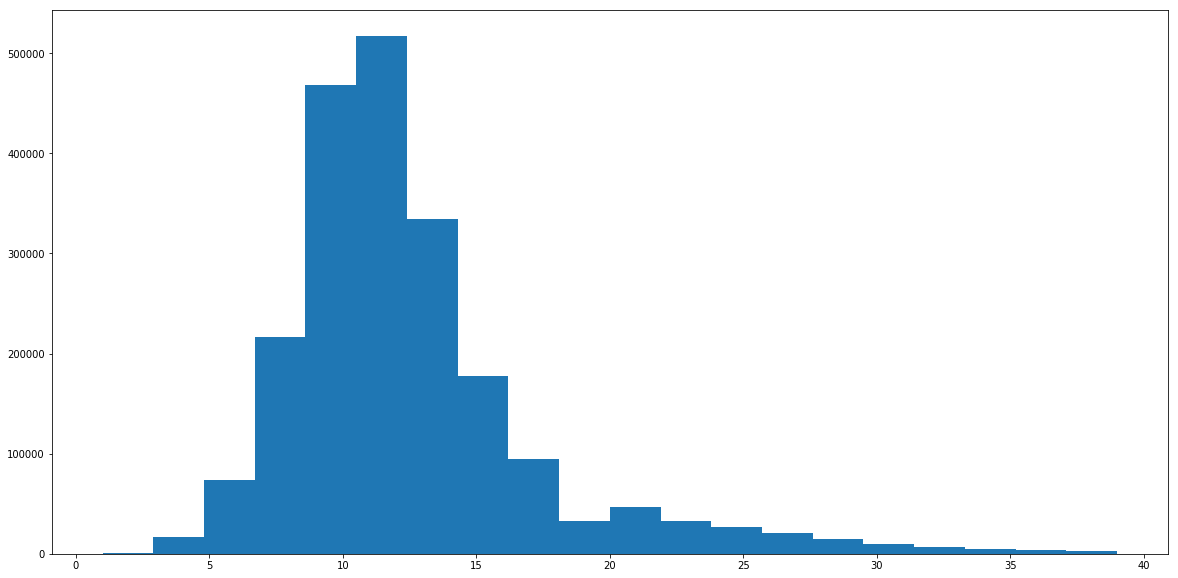

In [127]:
check = distance_test[(distance_test['distance'] > 0) & (distance_test['distance'] < 40)]
plt.figure(figsize = (20,10))
plt.hist(check['distance'] , bins = 20)
plt.show()

Will focus on the Names that have distance bellow 3 characters

In [128]:
check = distance_test[(distance_test['distance'] <= 3) & (distance_test['distance'] > 0)]
check=check[check['Artist_x'] != '']
print(len(check.drop_duplicates()))
check.drop_duplicates()

1910


Artist_x Artist_y  distance
30475      NSYNC   N SYNC         1
53034       10CC    10 CC         1
55035        112      USE         3
55058        112      CHE         3
55048        112       FP         3
...          ...      ...       ...
371851        ZO       YZ         2
1833094       ZO      RC2         3
245381       EJO      DDT         3
245372       EJO      PCP         3
2162590      EJO      ARA         3

[1910 rows x 3 columns]

In [129]:
to_test = check[check['distance'] == 3]
def blah(a):
    if len(a) <= 4:
        return(0)
    else:
        return(1)
to_test['blah'] = to_test.apply(lambda row:blah(row['Artist_x']) , axis = 1)
print(len(to_test))
print(len(to_test[to_test['blah'] == 1]))

to_test=to_test[to_test['blah'] == 1].drop_duplicates().reset_index()
to_test

3320
1112


D:\aa\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


index                         Artist_x  \
0     213560                            6LACK   
1     294099                            ATRAK   
2     302345                            ACHAL   
3     387643                            ADELE   
4     383360                            ADELE   
..       ...                              ...   
450   966985                            YANNC   
451   967388                            YAZOO   
452   263324                            YOSTE   
453   888725                           ZANSKI   
454  2072990  ZIGGY MARLEY  THE MELODY MAKERS   

                               Artist_y  distance  blah  
0                                 BRICK         3     1  
1                                  STAN         3     1  
2                                AMARAL         3     1  
3                                  DEUS         3     1  
4                                 SWELL         3     1  
..                                  ...       ...   ...  
450                               YAZOO         3     1  
451                                 AYO         3     1  
452                                VAST         3     1  
453                              MANSUN         3     1  
454  ZIGGY MARLEY AND THE MELODY MAKERS         3     1  

[455 rows x 5 columns]

**After exploring Artists names on the different datasets with distance less or equal to 3=>**

**I am changing some names so they are identical and I can apply merging!**

In [130]:
a=np.array([392290,1075760,1113494,1144684,1384073,1463622,1179517,1498871,1594879,1618686,1456622,1658873,1402282,318900,1775692,1402282,
318900,1775692,1755003,318900,617519,888788,907300,1843338,1874514,616855,1903771,1805991,1598455,1620875,1916469,1930292,
1822832,722810,1965764,1960476,1955490,638485,505605,1822832,1978407,2008371,2013861,1998406,6156,1557061,2020659,2033688,
1648330,332823,758933,2037399,2039018,1823081,749010,2033605,1486478,1280563,1038556,1519463,2100536,1525383,2097480,995247
,2115627,1828082,2115627,2116141,1306802] )
aa1=[to_test.iloc[i]['Artist_x'] for i in range(len(to_test)) if to_test.iloc[i]['index'] in a ]
bb1=[to_test.iloc[i]['Artist_y'] for i in range(len(to_test)) if to_test.iloc[i]['index'] in a ]
print(bb1)
print("\n",aa1)

['ADRIANNA CASELLOTI', 'ANGELS AND AIRWAVES', 'ARCHIE BELL AND THE DRELLS', 'ART BLAKEY AND THE JAZZ MESSENGERS', 'BELLE AND SEBASTIAN', 'BILLY CURRINGHAM', 'HBLOCKX', 'BOB MARLEY AND THE WAILERS', 'BLA FLECK  THE FLECKTONES', 'CARLOS VARELA', 'CHAKA DEMUS AND PLIERS', 'DJ CHEB I SABBAH', 'COHEED  CAMBRIA', 'COMMANDER CODY  HIS LOST PLANET AIRMEN', 'CROSBY STILLS NASH AND YOUNG', 'DANNY AND THE JUNIORS', 'BENNY MARTIN', 'DIAMOND REXX', 'DION AND THE BELMONTS', 'ECHO AND THE BUNNYMEN', 'ELMORE JAMES JR', 'LEELA JAMES', 'FRANKIE LYMON AND THE TEENAGERS', 'FRANKIE VALLI AND THE FOUR SEASONS', 'GARNET MIMMS AND THE ENCHANTERS', 'GENE HARRIS AND THE THREE SOUNDS', 'GEORGE THOROGOOD AND THE DESTROYERS', 'GRACE POTTER AND THE NOCTURNALS', 'HANK WILLIAMS JR', 'HERCULES AND LOVE AFFAIR', 'HOOTIE AND THE BLOWFISH', 'HUEY LEWIS AND THE NEWS', 'IKE AND TINA TURNER', 'IRON AND WINE', 'JUDE COLE', 'JASON BOLAND AND THE STRAGGLERS', 'JOHN LEE HOOKER JR', 'RISN MURPHY', 'JOHNNY THUNDERS AND THE HEARTB

Similar approach for distance equal to 2 and equal to 1

In [131]:
#Changes with distance =2 
to_test = check[check['distance'] == 2].drop_duplicates().reset_index()
#len(to_test.iloc[0]['Artist_y'])
#function so that artists that have only three letters are exluded

print(len(to_test))
to_test[200:]

b=[111024,258770,1056623,1498870,1652860,1374218,1652860,1725812,1212089,568160,720038,1937661,1938590,1957577,1986784,1989421,
1989421,1998014,2004828,2014910,1863502,1130194,1754026,2083261,1607057,2088608,2089748,2091749,2095369,70946,2111013,
2112376,2115677,1991641,920506,2134608,612300]

aa2=[to_test.iloc[i]['Artist_x'] for i in range(len(to_test)) if to_test.iloc[i]['index'] in b ]
bb2=[to_test.iloc[i]['Artist_y'] for i in range(len(to_test)) if to_test.iloc[i]['index'] in b ]
print(aa2)
bb2

215
['2PAC', 'A FLOCK OF SEAGULLS', 'ANDY WILLIAMS', 'BOB MARLEY  THE WAILERS', 'BOBBY V', 'CHARLIE MUSSELWHITE', 'CREEDENCE CLEARWATER REVIVAL', 'DIDDY', 'EN VOGUE', 'GRAVES', 'GUSTAVO SANTAOLALLA', 'GBOR SZAB', 'HSKER D', 'JIMI HENDRIX', 'JJ GREY  MOFRO', 'JOHNNY CLARKE', 'JOS GONZLEZ', 'JHANN JHANNSSON', 'LLOYD BANKS', 'MICHAEL FRANTI  SPEARHEAD', 'MILES DAVIS QUARTET', 'NILS PETTER MOLVR', 'OLGA TANON', 'OLIVIA NEWTONJOHN', 'ORSTEN', 'PANTEON ROCOCO', 'PEDRO SUREZVRTIZ', 'PLIES', 'ROCO DRCAL', 'RUBEN GONZALEZ', 'SAMMY ADAMS', 'SIR MIXALOT', 'STAIND', 'THE BARKAYS', 'TLPOPMUSIK']


['TUPAC',
 'FLOCK OF SEAGULLS',
 'DANNY WILLIAMS',
 'BOB MARLEYTHE WAILERS',
 'BOBBY',
 'CHARLES MUSSELWHITE',
 'CREEDENCE CLEARWATER REVIVED',
 'P DIDDY',
 'EN VOICE',
 'GRIEVES',
 'GUSTAVO A SANTAOLALLA',
 'GABOR SZABO',
 'HUSKER DU',
 'JIMMY HENDRIX',
 'JJ GREY MOFFRO',
 'JOHNNIE CLARKE',
 'JOSE GONZALEZ',
 'JOHANN JOHANNSSON',
 'LLYOD BANKS',
 'MICHAEL FRANTI  SUPERHEAD',
 'MILES DAVIS QUINTET',
 'NILS PETTER MOLVAER',
 'OLGA TAN',
 'OLIVIA NEWTON  JOHN',
 'ORTSEN',
 'PANTEN ROCOC',
 'PEDRO SUAREZVERTIZ',
 'PLEJ',
 'ROCIO DURCAL',
 'RUBN GONZLEZ',
 'SAM ADAMS',
 'SIR MIX A LOT',
 'SAINT',
 'THE BAR  KAYS',
 'TELEPOPMUSIK']

In [132]:
to_test = check[check['distance'] == 1].drop_duplicates().reset_index()


c = np.array(to_test['index'].unique())
aa3 = [to_test.iloc[i]['Artist_x'] for i in range(len(to_test)) if to_test.iloc[i]['index'] in c ]
bb3 = [to_test.iloc[i]['Artist_y'] for i in range(len(to_test)) if to_test.iloc[i]['index'] in c ]

Applying changes and merging

In [133]:

aa = np.concatenate((aa1,aa2,aa3))
bb = np.concatenate((bb1,bb2,bb3))
#Applying the changes
for i in range(len(bb)):
    songs['Artist'] = songs['Artist'].str.replace(bb[i],aa[i])
#Some minor alterations as well:
metrics['Song'] = metrics['Song'].str.replace(' - Live','')
metrics['Song'] = metrics['Song'].str.replace('- Live','')
    
#merging after the changes:
final_test = pd.merge(metrics , songs , on = ['Artist','Song'] , how = 'inner').drop_duplicates(['Song' , 'Artist'])
final_test

Artist                  Song        Genre  popularity  acousticness  \
0           !!!            Myth Takes   Electronic          41       0.13300   
1           !!!      Must Be The Moon   Electronic          39       0.00112   
2           !!!   Bend Over Beethoven   Electronic          36       0.00310   
3           !!!                Yadnus   Electronic          38       0.03640   
4      10 YEARS             Beautiful  Alternative          46       0.00227   
...         ...                   ...          ...         ...           ...   
50029    ZZ TOP            Give It Up        Blues          35       0.00812   
50030    ZZ TOP       Planet Of Women        Blues          38       0.02650   
50031    ZZ TOP        It'S Only Love        Blues          33       0.10800   
50032     Μ-ZIQ  Brace Yourself Jason   Electronic          34       0.12700   
50033     Μ-ZIQ      Hasty Boom Alert   Electronic          35       0.10800   

       danceability  energy  instrumentalness  liveness  loudness  \
0             0.754   0.770          0.747000    0.2930   -0.7830   
1             0.769   0.886          0.048400    0.3580   -0.5383   
2             0.630   0.927          0.739000    0.1820   -0.6540   
3             0.694   0.798          0.024000    0.0596   -0.6010   
4             0.497   0.748          0.000000    0.1360   -0.4500   
...             ...     ...               ...       ...       ...   
50029         0.664   0.665          0.000114    0.1490   -0.9881   
50030         0.462   0.863          0.000644    0.2710   -1.2964   
50031         0.700   0.592          0.018400    0.1180   -1.0434   
50032         0.546   0.734          0.932000    0.0501   -0.8808   
50033         0.520   0.858          0.834000    0.1170   -0.8718   

       speechiness     tempo  valence             song_id  \
0           0.0272  0.097109    0.904  SOYHNTG12A6D4F5703   
1           0.0459  0.120005    0.946  SORLTDE12A6D4F5705   
2           0.0457  0.120654    0.611  SOESDGT12A6D4F570A   
3           0.0725  0.126073    0.456  SOKCVIN12A6D4F5709   
4           0.0332  0.131944    0.274  SOILLEE12A58A7D291   
...            ...       ...      ...                 ...   
50029       0.0282  0.123950    0.530  SOKTBXM12A81C205CE   
50030       0.0343  0.075673    0.712  SOOUHHW12A81C205F9   
50031       0.0681  0.109847    0.906  SOVMYZF12A8C139CB4   
50032       0.0343  0.145867    0.447  SOCWFJI12A58A77319   
50033       0.0729  0.093834    0.215  SORZMHH12A58A7F434   

                      release  year  
0                  Myth Takes  2007  
1                  Myth Takes  2007  
2                  Myth Takes  2007  
3                  Myth Takes  2007  
4                    Division  2008  
...                       ...   ...  
50029  ZZ Top - Greatest Hits     0  
50030             Afterburner  1985  
50031     The ZZ Top Six Pack     0  
50032         Lunatic Harness  1997  
50033         Lunatic Harness  1997  

[20594 rows x 16 columns]

In [134]:
print(final_test.columns)
cols=['Artist', 'Song','acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'song_id','popularity']
final_test = final_test[cols]
final_test


Index(['Artist', 'Song', 'Genre', 'popularity', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'song_id', 'release', 'year'],
      dtype='object')


Artist                  Song  acousticness  danceability  energy  \
0           !!!            Myth Takes       0.13300         0.754   0.770   
1           !!!      Must Be The Moon       0.00112         0.769   0.886   
2           !!!   Bend Over Beethoven       0.00310         0.630   0.927   
3           !!!                Yadnus       0.03640         0.694   0.798   
4      10 YEARS             Beautiful       0.00227         0.497   0.748   
...         ...                   ...           ...           ...     ...   
50029    ZZ TOP            Give It Up       0.00812         0.664   0.665   
50030    ZZ TOP       Planet Of Women       0.02650         0.462   0.863   
50031    ZZ TOP        It'S Only Love       0.10800         0.700   0.592   
50032     Μ-ZIQ  Brace Yourself Jason       0.12700         0.546   0.734   
50033     Μ-ZIQ      Hasty Boom Alert       0.10800         0.520   0.858   

       instrumentalness  liveness  loudness  speechiness     tempo  valence  \
0              0.747000    0.2930   -0.7830       0.0272  0.097109    0.904   
1              0.048400    0.3580   -0.5383       0.0459  0.120005    0.946   
2              0.739000    0.1820   -0.6540       0.0457  0.120654    0.611   
3              0.024000    0.0596   -0.6010       0.0725  0.126073    0.456   
4              0.000000    0.1360   -0.4500       0.0332  0.131944    0.274   
...                 ...       ...       ...          ...       ...      ...   
50029          0.000114    0.1490   -0.9881       0.0282  0.123950    0.530   
50030          0.000644    0.2710   -1.2964       0.0343  0.075673    0.712   
50031          0.018400    0.1180   -1.0434       0.0681  0.109847    0.906   
50032          0.932000    0.0501   -0.8808       0.0343  0.145867    0.447   
50033          0.834000    0.1170   -0.8718       0.0729  0.093834    0.215   

                  song_id  popularity  
0      SOYHNTG12A6D4F5703          41  
1      SORLTDE12A6D4F5705          39  
2      SOESDGT12A6D4F570A          36  
3      SOKCVIN12A6D4F5709          38  
4      SOILLEE12A58A7D291          46  
...                   ...         ...  
50029  SOKTBXM12A81C205CE          35  
50030  SOOUHHW12A81C205F9          38  
50031  SOVMYZF12A8C139CB4          33  
50032  SOCWFJI12A58A77319          34  
50033  SORZMHH12A58A7F434          35  

[20594 rows x 13 columns]

### 4.5 Final Merge:


Last merge.

Dataset which contains all the attributes

In [135]:
total = pd.merge(artists , final_test , on = 'Artist' , how = 'inner').drop_duplicates()
total


Artist                         Tags              Song  \
0        KANYE WEST               Rnb,HipHop,Rap   Flashing Lights   
1        KANYE WEST               Rnb,HipHop,Rap     We Don'T Care   
2        KANYE WEST               Rnb,HipHop,Rap        Homecoming   
3        KANYE WEST               Rnb,HipHop,Rap      Good Morning   
4        KANYE WEST               Rnb,HipHop,Rap          I Wonder   
...             ...                          ...               ...   
13722     THE SEEDS  Psychedelic,60S,Rock,Garage  Pushin' Too Hard   
13723     THE SEEDS  Psychedelic,60S,Rock,Garage        Mr. Farmer   
13724     THE SEEDS  Psychedelic,60S,Rock,Garage       Evil Hoodoo   
13725  BRAND NUBIAN       Underground,HipHop,Rap           Wake Up   
13726  BRAND NUBIAN       Underground,HipHop,Rap         Slow Down   

       acousticness  danceability  energy  instrumentalness  liveness  \
0           0.03150         0.634   0.649          0.000000    0.4820   
1           0.01490         0.641   0.743          0.000000    0.2250   
2           0.32300         0.679   0.754          0.000000    0.1260   
3           0.09130         0.577   0.646          0.000042    0.1700   
4           0.13000         0.540   0.476          0.000252    0.1350   
...             ...           ...     ...               ...       ...   
13722       0.26700         0.535   0.654          0.000012    0.3180   
13723       0.00122         0.525   0.473          0.755000    0.0854   
13724       0.03890         0.231   0.909          0.000291    0.0575   
13725       0.01060         0.525   0.724          0.000012    0.0563   
13726       0.07980         0.731   0.857          0.000009    0.0772   

       loudness  speechiness     tempo  valence             song_id  \
0       -0.7505       0.0486  0.090482    0.509  SOOLPFK12A58A7BDE3   
1       -0.5784       0.1750  0.083140    0.612  SORKTWB12A8C1446E7   
2       -0.6965       0.1860  0.086993    0.905  SOIYWPZ12A81C204EF   
3       -0.5902       0.1300  0.169769    0.575  SOWPETC12A81C22AE3   
4       -0.8658       0.1110  0.191259    0.116  SOAWIDW12A81C22AEB   
...         ...          ...       ...      ...                 ...   
13722   -1.2434       0.0420  0.143612    0.827  SOHVAGH12A8C133471   
13723   -1.4971       0.0555  0.125870    0.723  SOALNTE12A8C133ED1   
13724   -1.3122       0.0761  0.154103    0.457  SOJWUOJ12A8C133EAA   
13725   -1.1282       0.1730  0.186531    0.910  SOPCSVF12AB01815A1   
13726   -1.3358       0.1900  0.095879    0.691  SOPZFGC12A6D4FADB4   

       popularity  
0              68  
1              53  
2              66  
3              64  
4              64  
...           ...  
13722          37  
13723          31  
13724          30  
13725          46  
13726          52  

[13727 rows x 14 columns]

Some Extra Steps:

 * Changing the format of the songs on the reviews Dataset(some Songs contained ( ... ) and  [...] so I get rid of them
 * Vectorizing the Tags to prepare them for the recommendation engine


In [136]:
colabor['Song'] = colabor['Song'].str.replace(" (\(.*?\))","")
colabor['Song'] = colabor['Song'].str.replace(" (\[.*?\])","")
colabor['Song'] = colabor['Song'].str.replace("(\(.*?\))","")
colabor['Song'] = colabor['Song'].str.replace("(\[.*?\])","")

#preprocess
colabor1 = pd.merge(colabor , songs , on = ['Song','Artist'] , how = 'inner')
del colabor1['song_id_x']
colabor1 = colabor1.rename(columns = {'song_id_y':'song_id'})

#Next dataset:
metrics_songs = pd.merge(metrics , songs , on = ['Song','Artist'] , how = 'inner').drop_duplicates(['Song','Artist'])

#tags set ready:
total_tags = total[['Artist','Tags']].drop_duplicates()
vect = CountVectorizer(lowercase = False)
AllTags = vect.fit_transform(total_tags['Tags'])
vectorized_tags = pd.DataFrame(index = total_tags['Artist'] , columns = vect.get_feature_names() , data = AllTags.toarray())
vectorized_tags_finder = vectorized_tags.reset_index()
vectorized_tags_finder

Artist  40S  50S  60S  70S  80S  8Bit  90S  AcidHouse  AcidJazz  \
0         KANYE WEST    0    0    0    0    0     0    0          0         0   
1           COLDPLAY    0    0    0    0    0     0    0          0         0   
2        TAME IMPALA    0    0    0    0    0     0    0          0         0   
3              QUEEN    0    0    0    0    1     0    0          0         0   
4          RADIOHEAD    0    0    0    0    0     0    0          0         0   
...              ...  ...  ...  ...  ...  ...   ...  ...        ...       ...   
2091    ELIANE ELIAS    0    0    0    0    0     0    0          0         0   
2092  THE SKATALITES    0    0    0    0    0     0    0          0         0   
2093     WIM MERTENS    0    0    0    0    0     0    0          0         0   
2094       THE SEEDS    0    0    1    0    0     0    0          0         0   
2095    BRAND NUBIAN    0    0    0    0    0     0    0          0         0   

      ...  Turntablism  Uk  Underground  Urban  VikingMetal  Vocal  WestCoast  \
0     ...            0   0            0      0            0      0          0   
1     ...            0   1            0      0            0      0          0   
2     ...            0   0            0      0            0      0          0   
3     ...            0   0            0      0            0      0          0   
4     ...            0   0            0      0            0      0          0   
...   ...          ...  ..          ...    ...          ...    ...        ...   
2091  ...            0   0            0      0            0      0          0   
2092  ...            0   0            0      0            0      0          0   
2093  ...            0   0            0      0            0      0          0   
2094  ...            0   0            0      0            0      0          0   
2095  ...            0   0            1      0            0      0          0   

      World  Worship  WuTang  
0         0        0       0  
1         0        0       0  
2         0        0       0  
3         0        0       0  
4         0        0       0  
...     ...      ...     ...  
2091      0        0       0  
2092      0        0       0  
2093      0        0       0  
2094      0        0       0  
2095      0        0       0  

[2096 rows x 269 columns]

### 5.Recommenation System
#### Model Approach: Hybrid

After testing many approaches such us :

* Average similarity distance between the user's input and all attributes on all datasets:
* Hierarchical Approach with different hierarchies

And considering that :

**Most people prefer to stick to the specific music genre they choose at specific times**

A hierarchical approach was picked.

### 5.1 The First step would be to find the Artists closer to the input Artist

A person who loves metal music wouldn't want to get a HipHop song that was voted highly from other metal lovers or share similar music attributes such as valence or energy


**A person who loves metal music wouldn't want to get a HipHop song that was voted highly from other metal lovers or share similar music attributes.**





### Next: All songs of the Artists which are close to the Artist the user picked are gathered

**NOTE**: A limitation mentioned before was the small number of common artists and songs in the two datasets , with regards to their total individual size.

**By applying the steps mentioned before, the total number of common artists and songs on the merged DataSets was raised**


### 5.2 Filter out the totally irrelevant songs 
#### From the list of Songs of the Artists which are close to the Artist the User picked: 

The songs which have the less similar metadata are filtered out.

For example: 
* Chara chooses an acoustic sad song from a Rock Artist. 
* She probably is sad and wants to relax
* She wants acoustic sad songs from Rock Artists

**Metrics content based Dataset can identify these song’s features**

Out of all the songs selected in the first step:

**Model will choose those that have similar music features.**

Filtering out the irrelevant songs was fundamental in making accurate predictions




### 5.3 Playlist Production Based on Collaborative Filtering

Out of the remaining pool of songs:

**Similarity between songs(item based),based on user reviews,will be counted and the closest 20 songs will be produced.**

This would also avoid the big calculation time based on the high sparsity of collaborative filtering dataset as slow recommendations are considered bad recommendations.

### Model's Algorithm:

* After user entered a song and its artists, a search on all three datasets would take place. If the entered Artists is matched,then the song would be searched.
* In case the Artist is not found,recommendation wont take place. 
* If the Artist is matched but the specific song is not found, the songs of the entered Artists existing on all three datasets would be proposed for a new search 

**First hierarchical approach used K-NN with pearson correlation to find the 100 closest artists to user's initial artists input.**

Number 100 was chosen because :
* It is a balanced number considering the total length of 10.000 Artists
* Will create many songs for the other two models

**Approximately, 500-600 songs were generated from the first dataset(Artists Dataset).**
Out of these songs:
* 200 songs would filtered out on the second step
* K-NN will be used with pearson correlation again.
* 300 closest songs will be kept for the final step

**In the final Step,out of 300 songs a playlist of top 20 would be selected(according to other user's preferences)**

#### With this approach:

Despite having a few songs,the big number of artists(features) resulted in good recommendations.

**In addition**
A list of the closest artists will also be generated and recommended, based on the artists dataset so user can check different artists which are close to its selection


### Preparing the functions:

In [137]:
def closest_Artists(Artist):
    nbrs = NearestNeighbors(n_neighbors = 100 , algorithm = 'brute' , metric = 'correlation').fit(vectorized_tags)
    distances, indices = nbrs.kneighbors(vectorized_tags.as_matrix())

    distances1, indices1 = nbrs.kneighbors(vectorized_tags.loc[Artist].as_matrix().reshape(1,-1))
    #print('Closest to',indices1[0,:1],'the predictions:')
    vals = []
    j = 1
    for i in indices1[0,1:]:
        #print(vectorized_tags_finder.iloc[i]['Artist'],distances1[0,j])
        vals.append(vectorized_tags_finder.iloc[i]['Artist'])
        #j=j+1
    return(vals)
def collaborative_search(song_id,Song,filter1,filter11,close_artists,artist):
    colabor_filter = colabor1.loc[(colabor1['Song'] == Song)|(colabor1['song_id'].isin(filter11))]
    colabor_filter = colabor_filter[(colabor_filter['Song'] == Song)|(colabor_filter['Artist'] != artist)]

    vectorized_reviews = colabor_filter.pivot_table(index = 'song_id' , columns = 'user' , values = 'play_count').fillna(0)
    vectorized_reviews_finder = vectorized_reviews.reset_index()
    


    nbrs = NearestNeighbors(n_neighbors = 20, algorithm = 'brute' , metric = 'cosine').fit(vectorized_reviews)
    distances, indices = nbrs.kneighbors(vectorized_reviews.as_matrix())

    distances1, indices1 = nbrs.kneighbors(vectorized_reviews.loc[song_id].as_matrix().reshape(1,-1))
    recommended =  []
    j = 0
    for i in indices1[0,:]:
        #print(vectorized_reviews_finder.iloc[i]['song_id'],distances1[0,j])
        recommended.append(vectorized_reviews_finder.iloc[i]['song_id'])
        #j=j+1
 
    return(recommended)

def collaborative_artists(Artist,close_artists,number):
    colabor_filter = colabor1.loc[(colabor1['Artist'].isin(close_artists))]
    vectorized_reviews = colabor_filter.pivot_table(index = 'Artist' , columns = 'user' , values = 'play_count').fillna(0)
    vectorized_reviews_finder = vectorized_reviews.reset_index()
    nbrs = NearestNeighbors(n_neighbors = number , algorithm = 'brute' , metric = 'cosine').fit(vectorized_reviews)
    distances, indices = nbrs.kneighbors(vectorized_reviews.as_matrix())

    distances1, indices1 = nbrs.kneighbors(vectorized_reviews.loc[Artist].as_matrix().reshape(1,-1))
#print('Closest to',indices1[0,:1],'the predictions:')
    recommended=[]
    j=0
    for i in indices1[0,:]:
        #print(vectorized_reviews_finder.iloc[i]['song_id'],distances1[0,j])
        recommended.append(vectorized_reviews_finder.iloc[i]['Artist'])
        #j=j+1
    return(recommended)

    

def metrics_search(Song,close_artists):
    metrics_filtered = metrics_songs.loc[(metrics_songs['Artist'].isin(close_artists))|(metrics_songs['Song']==Song)]
    metrics_values =  metrics_filtered[['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 
                                     'loudness', 'speechiness', 'tempo','valence']]
    
    nbrs = NearestNeighbors(n_neighbors = 300, algorithm = 'brute' , metric = 'cosine').fit(metrics_values)
    distances, indices = nbrs.kneighbors(metrics_values)


    test1=(metrics_filtered[metrics_filtered['Song']==Song][['acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']]).as_matrix()
    distances1, indices1 = nbrs.kneighbors(test1)
    songs_names = []
    songs_ids = []
   # j=0
    for i in indices1[0,:]:
   #     print(metrics_filtered.iloc[i]['Song'],' distance = ',distances1[0,j])
    #    print(metrics_filtered.iloc[i]['Artist'])
   # print('///////////\\\\\\\\\\\\\\')
        songs_names.append(metrics_filtered.iloc[i]['Song'])
        songs_ids.append(metrics_filtered.iloc[i]['song_id'])
    return(songs_names,songs_ids)

    

def recommandation(Song,Artist):
    Song = Song.title()
    Artist = Artist.upper()
    try:
    #if (0==0):
        artist_songs_in_colabor = colabor1[colabor1['Artist']==Artist]
        artist_songs_in_metrics = metrics_songs[metrics_songs['Artist']==Artist]
        error_test1 = artist_songs_in_colabor.iloc[0]
        error_test2 = artist_songs_in_metrics.iloc[0]
 
        
        print('Artist Match')
          
        try:
        #if (1==1):
            song_id = colabor1[(colabor1['Song'] == Song) & (colabor1['Artist'] == Artist)].iloc[0]['song_id']
            song_id2 = metrics_songs[(metrics_songs['Song'] == Song) & (metrics_songs['Artist'] == Artist)].iloc[0]['song_id']
            print('\nSong Matched')
            print('\n Preparing Recommandations for:')
        
            print(Song,', by ,',Artist)
            print('...................................')
            close_artists=closest_Artists(Artist)
    #print(close_artists)
            filter1,filter11 = metrics_search(Song,close_artists)
            filter2 = collaborative_search(song_id , Song , filter1 , filter11 , close_artists , Artist)
            #print(filter2)
            final = colabor1.loc[colabor1['song_id'].isin(filter2)].drop_duplicates(['Song','Artist'])
            final = final[final['Song']!=Song]
            final_songs = final['Song'].values
            final_artists = final['Artist'].values
            for i in range(len(final_songs)):
                print(final_songs[i],' by ',final_artists[i])
            print('...................................')
            print('\nRecommended Artists:')
            Artists2 = closest_Artists(Artist)
            Artists2.append(Artist)
            print(collaborative_artists(Artist,Artists2,10))
            
    
        
    
        except:
            print('Oops')
            print('Song Not Found')
            print('Try Again If you like one of the following songs by:',Artist)
            print(pd.merge(artist_songs_in_colabor,artist_songs_in_metrics,how='inner',on='Song')['Song'].unique())
    except:
        print('Artist Not Found,try again')  


In [138]:
recommandation("Day 'N' Nite",'kid cudi')

Artist Match

Song Matched

 Preparing Recommandations for:
Day 'N' Nite , by , KID CUDI
...................................
The Light  by  COMMON
The New Workout Plan  by  KANYE WEST
Stronger  by  KANYE WEST
Just Lose It  by  EMINEM
Puppets  by  ATMOSPHERE
Definition  by  BLACK STAR
E.I.  by  NELLY
Black Mags  by  THE COOL KIDS
My Name Is  by  EMINEM
The Real Slim Shady  by  EMINEM
P.I.M.P.  by  50 CENT
Sure Shot  by  BEASTIE BOYS
Through The Wire  by  KANYE WEST
Mass Appeal  by  GANG STARR
Runnin'  by  THE PHARCYDE
Method Man  by  WU-TANG CLAN
...................................

Recommended Artists:
['KID CUDI', 'DJ KHALED', 'EMINEM', 'LUPE FIASCO', 'COMMON', 'KANYE WEST', 'LUDACRIS', 'CHIDDY BANG', 'WIZ KHALIFA', 'BEASTIE BOYS']


In [139]:
metrics[metrics['Artist']=='MASTODON']

Artist                Song             Genre  popularity  \
154023  MASTODON   Blood And Thunder              Rock          60   
10526   MASTODON      The Motherload       Alternative          53   
6271    MASTODON   Blood And Thunder       Alternative          56   
11701   MASTODON       Steambreather       Alternative          49   
101404  MASTODON      The Motherload  Children’s Music          55   
100370  MASTODON       Show Yourself  Children’s Music          57   
98737   MASTODON   Blood And Thunder  Children’s Music          60   
10720   MASTODON       Show Yourself       Alternative          52   
10200   MASTODON            Oblivion       Alternative          52   
100616  MASTODON            Oblivion  Children’s Music          55   
101378  MASTODON       Steambreather  Children’s Music          55   
13347   MASTODON  Stairway To Heaven       Alternative          50   

        acousticness  danceability  energy  instrumentalness  liveness  \
154023      0.000009         0.364   0.935          0.729000    0.0317   
10526       0.000007         0.363   0.971          0.003580    0.0797   
6271        0.000009         0.364   0.935          0.729000    0.0317   
11701       0.000041         0.358   0.981          0.000674    0.1840   
101404      0.000007         0.363   0.971          0.003580    0.0797   
100370      0.000005         0.468   0.977          0.021300    0.0543   
98737       0.000009         0.364   0.935          0.729000    0.0317   
10720       0.000005         0.468   0.977          0.021300    0.0543   
10200       0.000099         0.261   0.938          0.010600    0.3010   
100616      0.000099         0.261   0.938          0.010600    0.3010   
101378      0.000041         0.358   0.981          0.000674    0.1840   
13347       0.030100         0.271   0.624          0.003200    0.0737   

        loudness  speechiness     tempo  valence  
154023   -0.6548       0.0724  0.092717    0.478  
10526    -0.2974       0.0776  0.146018    0.347  
6271     -0.6548       0.0724  0.092717    0.478  
11701    -0.4572       0.1160  0.165027    0.262  
101404   -0.2974       0.0776  0.146018    0.347  
100370   -0.4198       0.0645  0.134996    0.493  
98737    -0.6548       0.0724  0.092717    0.478  
10720    -0.4198       0.0645  0.134996    0.493  
10200    -0.5125       0.0860  0.132470    0.256  
100616   -0.5125       0.0860  0.132470    0.256  
101378   -0.4572       0.1160  0.165027    0.262  
13347    -0.6733       0.0309  0.074611    0.242

In [140]:
colabor[colabor['Artist']=='MASTODON']['Song'].unique()

array(['Colony Of Birchmen', 'Divinations', 'Crack The Skye',
       'The Last Baron', 'Sleeping Giant'], dtype=object)

In [141]:
metrics[metrics['Artist']=='MASTODON']['Song'].unique()

array(['Blood And Thunder', 'The Motherload', 'Steambreather',
       'Show Yourself', 'Oblivion', 'Stairway To Heaven'], dtype=object)